In [1]:
#!pip install kramersmoyal
import pandas as pd
import numpy as np
from kramersmoyal import km

import os
import pickle
   

from utils.Data_cleaning import data_cleaning
from utils.Functions import data_filter, integrate_omega, KM_Coeff_1, KM_Coeff_2, daily_profile, power_mismatch, exp_decay, Euler_Maruyama, Increments, autocor 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from pysindy.feature_library import FourierLibrary
from pysindy.feature_library import CustomLibrary
from pysindy.optimizers import SR3
from scipy.ndimage import gaussian_filter1d
#import sdeint

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

#### Choose the grid: (Balearic, Irish or Iceland)

In [3]:
#grids = ['IS02','IRL01','ES_PM01']  
#grids = ['Balearic','Irish','Iceland' ]  
#grids = ['Iceland']  
#grids = ['Irish']
grids = ['Balearic']

In [4]:
dict_grids = {'Balearic':'ES_PM01','Irish':'IRL01','Iceland':'IS02'}
#dict_freq_grids = {'Balearic':'f50_ES_PM','Irish':'f50_IRL01'}
dict_freq_grids = {'Balearic':'f50_ES_PM','Irish':'f50_IRL01','Iceland':'f50_IS' }

In [5]:
models = ['model 1','model 2','model 3','model 4']

#freq_orig = data/(2*np.pi+50)
#increments_orig = Increments(data/(2*np.pi+50))

'''For calculations: use angular velocity omega = 2*pi*frequency '''
'''The bandwidth is chosen such that we receive a scmooth distribution'''

'''Choose the grid '''

'''Data analysis of the original time series'''
data_orig          = {i:[]for i in grids}



edges_1d     = {i:[]for i in grids}
drift_1d     = {i:[]for i in grids}
diffusion_1d = {i:[]for i in grids}
edges_2d     = {i:[]for i in grids}
kmc_2d       = {i:[]for i in grids}

for grid in grids:
    time_res = 1
    '''Choose the grid '''
    #raw=pd.read_csv('./Data/Frequency_data_%s.csv'%(grid), sep=',')  
    #freq = (raw[['Frequency']]/1000 +50).squeeze()
    #freq = data_cleaning(freq)
    
    raw=pd.read_csv('Data/%s.csv'%(dict_grids[grid]), sep=';')  
    freq = (raw[[dict_freq_grids[grid]]]/1000 +50).squeeze()
    freq = data_cleaning(freq)
    
    #print(freq)


    data_orig[grid].append(freq)
   

Number of too high frequency values:  0 Number of too low frequency values:  0
Number of too large increments:  88
Number of windows with constant frequency for longer than 60s:  0
Number of Nan-intervals:  0
Clean corrupted data ...


The empirical data is given by data_orig[grid] (grid = Irish, Iceland, Balearic.)
In the following the different models are calculated, i.e. the synthetic time series is given by "omega_synth_model_i" (i=1,2,3,4).
\
The default length of the calculated synthetic time series is 5 days (t_final=5).
\
The time step delta_t should be chosen smaller or equal than one. Here we use delta_t = 0.1.

In [6]:
def extract_data (data_set, n=900):
    """
    Extract  'omega' and 'theta' from the given dataset.
    """
    # Check if the dataset is not empty
    if data_set:
        omega = data_set[0][0]
        theta = data_set[0][1]

        
        omega_extract = omega[:n]
        theta_extract = theta[:n]

        return omega_extract, theta_extract

In [7]:
def integrate_data(data, dt=1):
    """
    Manually integrate the data using a simple Euler integration method.

    Parameters:
    data (array): The input data to be integrated.
    dt (float): The time step for integration.

    Returns:
    integrated_data: The integrated data.
    """
    
    integrated_data = np.zeros(len(data))
    for i in range(1, len(data)):
        integrated_data[i] = integrated_data[i-1] + data[i] * dt
    return integrated_data

### Model 2 case A, B, and C

In [8]:
'''Model 2...'''
np.random.seed(12345678)
noise_data_model_2 = {i:[]for i in grids}
ideal_data_model_2 = {i:[]for i in grids}
time_data_model_2 = {i:[]for i in grids}
c_1_model2 = {i:[]for i in grids}
c_2_model2 = {i:[]for i in grids}
epsilon_model2 = {i:[]for i in grids}

'''adapt the parameter estimation to the particulat grids'''
for grid in grids:

    #raw=pd.read_csv('./Data/Frequency_data_%s.csv'%(grid), sep=',')
    #freq = (raw[['Frequency']]/1000 +50).squeeze()
    #freq = data_cleaning(freq)
    
    raw=pd.read_csv('Data/%s.csv'%(dict_grids[grid]), sep=';')  
    freq = (raw[[dict_freq_grids[grid]]]/1000 +50).squeeze()
    freq = data_cleaning(freq)
    
    data = (freq-50)*(2*np.pi)   #Use the angular velocity for the calcualltions

    trend = 1 #trend is boolean
    bw_drift = 0.1
    bw_diff = 0.1
    dist_drift = 500    #for large data set: dist_drift = 350 for Balearic
    dist_diff = 500
    if grid == 'Balearic':
        Delta_P = power_mismatch(data,avg_for_each_hour = False,dispatch=2,start_minute=0,end_minute=1/6,length_seconds_of_interval=5)
        dispatch = 1
    elif grid == 'Irish':
        Delta_P = power_mismatch(data_filter(data,sigma = 6),avg_for_each_hour = False,dispatch=1,start_minute=0,end_minute=1/6,length_seconds_of_interval=5)
        dispatch = 2
        #we use a filter for the power mismatch of the Iroish data because of regular outliers (every 60 seconds)
    elif grid == 'Iceland':
        Delta_P = 0
        dispatch = 0
        trend = 0 # Represents a no-existing trend as there is no power dispatch schedule
        
    c_1 = KM_Coeff_1(data - trend*data_filter(data),dim= 1,time_res = 1,bandwidth = bw_drift,dist = dist_drift, order = 1)
    c_2_decay = trend*exp_decay(data,time_res=1,size = 899)
    epsilon =   epsilon = KM_Coeff_2(data - trend*data_filter(data),dim = 1,time_res = 1,bandwidth = bw_diff,dist = dist_diff,multiplicative_noise = False)
    #epsilon = 0

    kmc,edges = km(data - trend * data_filter(data),powers = [0,1,2],bins = np.array([6000]),bw=bw_drift)
    edges_1d[grid] = edges[0]
    drift_1d[grid] = kmc[1]
    diffusion_1d[grid] = kmc[2] 
    c_1_model2[grid] = c_1
    c_2_model2[grid] = c_2_decay * c_1
    epsilon_model2[grid] = epsilon

    delta_t = 1 #time step for Euler-Maruyama
    
    # with noise there are 96 intervals of 15 minutes each in one day.
    omega_noise_model_2, theta_noise_model_2, p1 = Euler_Maruyama(data,c_1=c_1,c_2_decay=c_2_decay,Delta_P = Delta_P,
                                                              epsilon=epsilon,time_res = 1,dispatch = dispatch,
                                                              delta_t=delta_t,t_final=900*96*30,model=2,factor_daily_profile=0,sawtooth = False)
    # without noise, set epsilon = 0
    omega_ideal_model_2, theta_ideal_model_2, p2= Euler_Maruyama(data,c_1=c_1,c_2_decay=c_2_decay,Delta_P = Delta_P,
                                                              epsilon=0,time_res = 1,dispatch = dispatch,
                                                              delta_t=delta_t,t_final=900*96*30,model=2,factor_daily_profile=0,sawtooth = False)
    # with sawtooth = True
    omega_time_model_2, theta_time_model_2, p3= Euler_Maruyama(data,c_1=c_1,c_2_decay=c_2_decay,Delta_P = Delta_P,
                                                              epsilon=epsilon,time_res = 1,dispatch = dispatch,
                                                              delta_t=delta_t,t_final=900*96*30,model=2,factor_daily_profile=0,sawtooth = True)
    
    #freq_synth_model_2 = omega_synth_model_2/(2*np.pi) + 50

    noise_data_model_2[grid].append((omega_noise_model_2, theta_noise_model_2))
    ideal_data_model_2[grid].append((omega_ideal_model_2, theta_ideal_model_2))
    time_data_model_2[grid].append((omega_time_model_2, theta_time_model_2))


    

Number of too high frequency values:  0 Number of too low frequency values:  0
Number of too large increments:  88
Number of windows with constant frequency for longer than 60s:  0
Number of Nan-intervals:  0
Clean corrupted data ...


In [9]:
Bal_noise = noise_data_model_2['Balearic']
Bal_ideal = ideal_data_model_2['Balearic']
Bal_time = time_data_model_2['Balearic']

In [10]:
import pickle

# Save Bal_noise to a file
with open('Bal_noise.pkl', 'wb') as file:
    pickle.dump(Bal_noise, file)

# Save Bal_ideal to a file
with open('Bal_ideal.pkl', 'wb') as file:
    pickle.dump(Bal_ideal, file)
    
# Save Bal_time to a file
with open('Bal_time.pkl', 'wb') as file:
    pickle.dump(Bal_time, file)


In [ ]:
# Load Bal_noise from the file
with open('Bal_noise.pkl', 'rb') as file:
    Bal_noise = pickle.load(file)

# Load Bal_ideal from the file
with open('Bal_ideal.pkl', 'rb') as file:
    Bal_ideal = pickle.load(file)

# Load Bal_time from the file
with open('Bal_time.pkl', 'rb') as file:
    Bal_time = pickle.load(file)

In [11]:
omega_Bal_noise, theta_Bal_noise = extract_data(Bal_noise,n=900*96*30)

In [12]:
omega_Bal_ideal, theta_Bal_ideal = extract_data(Bal_ideal,n=900*96*30)

In [13]:
omega_Bal_time, theta_Bal_time = extract_data(Bal_time,n=900*96*30)

In [14]:
np.mean(p1)

0.01091483851519431

In [15]:
np.mean(p2)

0.01091483851519431

In [30]:
np.mean(p3)

-7.018285179732076e-10

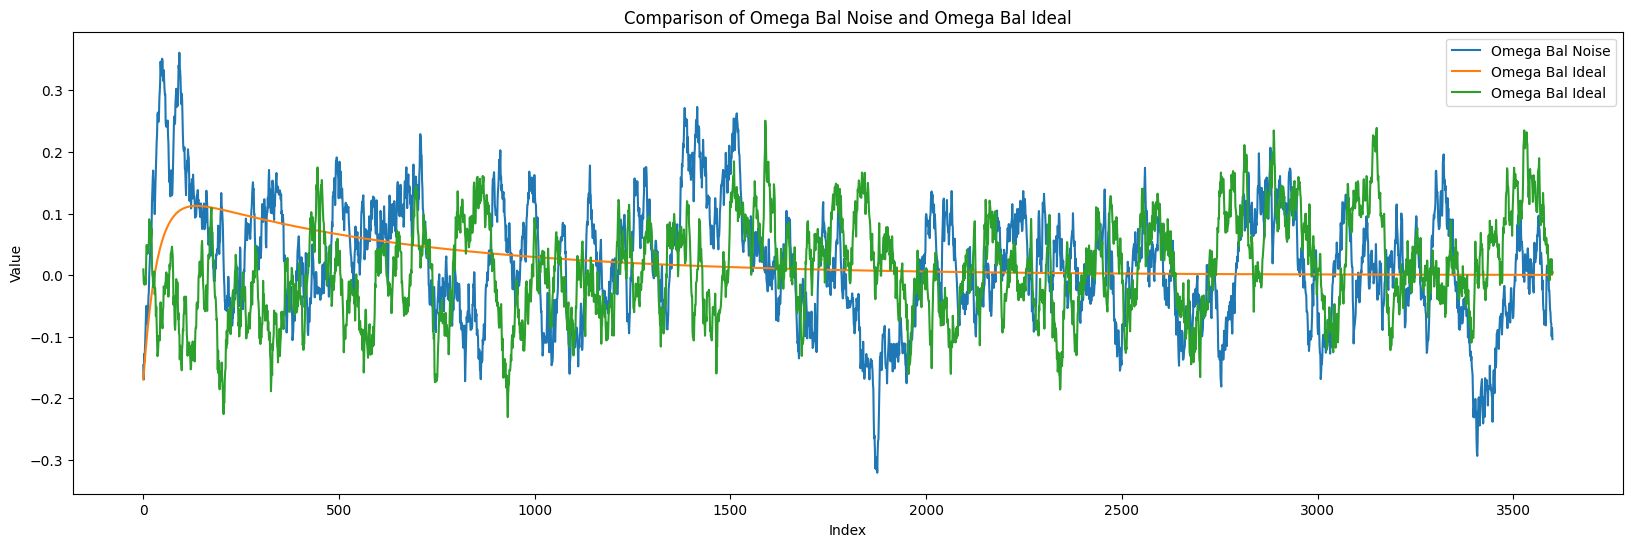

In [22]:
plt.figure(figsize=(20, 6))  # Adjust the size as needed

plt.plot(omega_Bal_noise[:900*4+1] ,label='Omega Bal Noise')
plt.plot(omega_Bal_ideal[:900*4+1],label='Omega Bal Ideal')
plt.plot(omega_Bal_time[:900*4+1],label='Omega Bal Ideal')

plt.legend()  # Show legend if multiple lines are plotted
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Omega Bal Noise and Omega Bal Ideal')

plt.show()

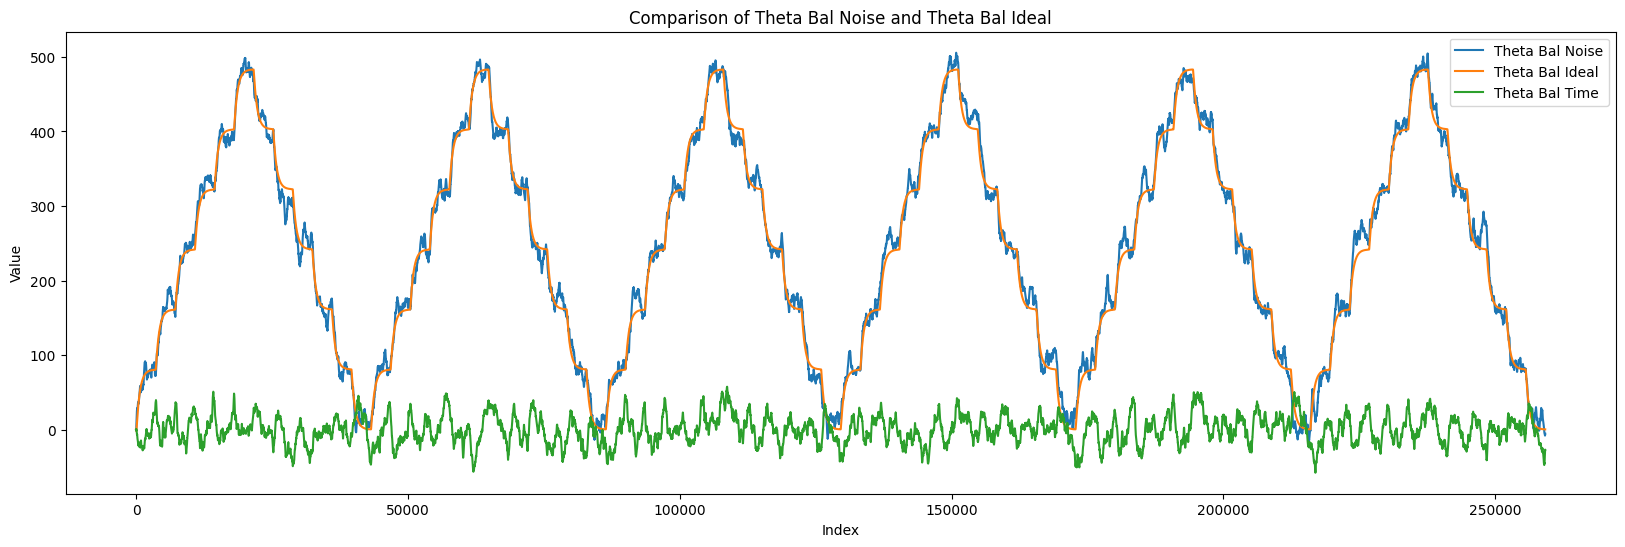

In [23]:
plt.figure(figsize=(20, 6))  # Adjust the size as needed

plt.plot(theta_Bal_noise[:900*96*3], label='Theta Bal Noise')
plt.plot(theta_Bal_ideal[:900*96*3], label='Theta Bal Ideal')
plt.plot(theta_Bal_time[:900*96*3], label='Theta Bal Time')

plt.legend()  # Show legend if multiple lines are plotted
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Theta Bal Noise and Theta Bal Ideal')

plt.show()

## Linear noise-free validation model

In [23]:
omega_df = pd.DataFrame({'omega': omega_Bal_ideal})
theta_df = pd.DataFrame({'theta': theta_Bal_ideal})

# Combine omega and theta DataFrames into a single DataFrame
combined_df = pd.concat([omega_df, theta_df], axis=1)

# Define the new list to hold the chunked DataFrames
chunked_data = []

# Number of points in each chunk
chunk_size = 900*4

# Calculate the number of chunks needed
num_chunks = len(combined_df) // chunk_size

# Split the DataFrame into chunks
for j in range(num_chunks):
    # Extract the chunk
    chunk = combined_df.iloc[j * chunk_size:(j + 1) * chunk_size].copy()

    # Label the chunk with the region name
    chunk['Region'] = 'Balearic'

    # Append the chunk to the list
    chunked_data.append(chunk)

# If there are remaining data points
if len(combined_df) % chunk_size != 0:
    remaining_chunk = combined_df.iloc[num_chunks * chunk_size:].copy()
    
    # Label the remaining chunk with the region name
    remaining_chunk['Region'] = 'Balearic'
    
    # Append the remaining chunk to the list
    chunked_data.append(remaining_chunk)




In [55]:
def noiseless_sindy_models(region_data, region_name):
    # Initialize an empty list for sindy_models
    sindy_models = []

    # Iterate over each chunk
    for chunk in region_data:
        # Integrate omega_filtered to get theta
        theta_chunk = chunk['theta'].values

        # Stack normalized theta and omega_filtered
        stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega'].values))

        # Generate time values
        t_train_chunk = np.arange(0, len(stacked_data_chunk), 1)

        # Add time as a linear feature
        linear_time_feature_chunk = t_train_chunk.reshape(-1, 1)
        x_train_augmented_chunk = np.hstack([stacked_data_chunk, linear_time_feature_chunk])
        #x_train_augmented_chunk = np.hstack([stacked_data_chunk])

        # Feature names for SINDy (including a linear term for time)
        feature_names_chunk = ["theta", "omega", "time"]
        #feature_names_chunk = ["theta", "omega"]

        # Use Polynomial Library 
        polynomial_library_chunk = ps.PolynomialLibrary(degree=2)

        # Sparse regression optimizer
        sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-10)

        # Create a SINDy model with the polynomial library
        model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                               feature_library=polynomial_library_chunk,
                               optimizer=sparse_regression_optimizer_chunk)

        # Fit the SINDy model using the chunk data
        model_chunk.fit(x_train_augmented_chunk, t=1)

        # Append the SINDy model to the list
        sindy_models.append(model_chunk)

        # Print the learned model for the current chunk
        print(f"Model for {region_name} - Chunk {len(sindy_models)}:")
        model_chunk.print(precision=7)
        print("Model Score:", model_chunk.score(x_train_augmented_chunk, t=1))
        print()

    # Initialize empty lists for coefficient matrices
    coefficients_matrices = []

    # Iterate over each SINDy model in sindy_models
    for model in sindy_models:
        # Get the coefficients from the model
        coefficients = model.coefficients()

        # Append the coefficients to the list
        coefficients_matrices.append(coefficients)

    # Convert the list of matrices to a 3D NumPy array
    coefficients_array = np.array(coefficients_matrices)

    # Calculate mean and standard deviation along the first axis (axis=0) which corresponds to chunks
    mean_coefficients = np.mean(coefficients_array, axis=0)
    std_coefficients = np.std(coefficients_array, axis=0)

    # Print mean_coefficients and std_coefficients 
    print(f"Mean Coefficients for {region_name}:")
    print(mean_coefficients)
    print(f"Standard Deviation of Coefficients Coefficients for {region_name}:")
    print(std_coefficients)
    
    return sindy_models



In [56]:
def noiseless_sindy_models_abs(region_data, region_name):
    sindy_models = []
    coefficients_matrices = []  # Initialize outside the models loop

    for chunk in region_data:
        # Integrate omega_filtered to get theta
        theta_chunk = chunk['theta'].values

        # Stack normalized theta and omega_filtered
        stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega'].values))

        # Generate time values
        t_train_chunk = np.arange(0, len(stacked_data_chunk), 1)

        # Add time as a linear feature
        linear_time_feature_chunk = t_train_chunk.reshape(-1, 1)
        x_train_augmented_chunk = np.hstack([stacked_data_chunk, linear_time_feature_chunk])
        #x_train_augmented_chunk = np.hstack([stacked_data_chunk])

        # Feature names for SINDy (including a linear term for time)
        feature_names_chunk = ["theta", "omega", "time"]
        #feature_names_chunk = ["theta", "omega"]

        # Use Polynomial Library 
        polynomial_library_chunk = ps.PolynomialLibrary(degree=2)

        # Sparse regression optimizer
        sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-10)

        # Create a SINDy model with the polynomial library
        model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                               feature_library=polynomial_library_chunk,
                               optimizer=sparse_regression_optimizer_chunk)

        # Fit the SINDy model using the chunk data
        model_chunk.fit(x_train_augmented_chunk, t=1)

        # Append the SINDy model to the list
        sindy_models.append(model_chunk)

        # Print the learned model for the current chunk
        #print(f"Model for {region_name} - Chunk {len(sindy_models)}:")
        #model_chunk.print(precision=7)
        #print("Model Score:", model_chunk.score(x_train_augmented_chunk, t=1))
        #print()

    for model in sindy_models:
        coefficients = model.coefficients()
        feature_names = model.get_feature_names()

        # Handling the presence of specific features
        time_indices = [feature_names.index(f) for f in feature_names if 'time' in f]

        # Take the absolute value of specific coefficients
        for idx in time_indices:
            coefficients[:, idx] = np.abs(coefficients[:, idx])

        coefficients_matrices.append(coefficients)

    # Convert to a 3D NumPy array and calculate mean and standard deviation
    coefficients_array = np.array(coefficients_matrices)
    mean_coefficients = np.mean(coefficients_array, axis=0)
    std_coefficients = np.std(coefficients_array, axis=0)

    print(f"Mean Coefficients for {region_name}:")
    print(mean_coefficients)
    print(f"Standard Deviation of Coefficients for {region_name}:")
    print(std_coefficients)

    return sindy_models


In [57]:
def noiseless_simulate_sindy_model(model, initial_conditions, time_points, title, omega_original):
    # Simulate the system using the provided model
    simulated_data = model.simulate(initial_conditions, time_points)

    # Extract simulated theta and omega
    simulated_theta = simulated_data[:, 0]
    simulated_omega = simulated_data[:, 1]

    # Plot the simulation results
    plt.figure(figsize=(10, 4))

    # Plot the original Omega with noise
    plt.plot(omega_original, label='Linear Noise-Free', alpha=0.7, color='#2b6a99')

    # Plot the simulated Omega
    plt.plot(simulated_omega, label='Simulated Omega', linestyle='--', linewidth=3, color='#f16c23')

    plt.title(f'Comparison of Linear Noise-Free and Simulated Omega - {title}', fontsize=16)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Omega', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    plt.legend(fontsize=16,frameon=False)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()


In [58]:
balearic_ideal = chunked_data
ideal_abs_models = noiseless_sindy_models_abs(balearic_ideal, 'Balearic')

Mean Coefficients for Balearic:
[[-5.16975918e-03  2.34518864e-05  9.34315646e-01  9.67335157e-05
  -2.57006188e-08 -1.68690448e-05  3.97037255e-07 -5.33055705e-04
   2.45549164e-04  7.63171461e-13]
 [ 1.10696926e-02 -4.58562398e-05 -2.78515932e-02  2.45615952e-06
   7.23330609e-10  4.74802986e-07  1.02212267e-08  1.50101313e-05
   6.31691735e-06  1.98158081e-15]
 [ 1.00000000e+00 -9.77734295e-12 -3.16957710e-09  5.69755179e-13
   2.03269337e-14  1.31786883e-11  2.36632068e-15  3.76841642e-10
   1.46364087e-12  1.35005002e-20]]
Standard Deviation of Coefficients for Balearic:
[[3.51828699e-01 1.91234585e-03 6.20045719e-01 5.73789161e-05
  3.41254715e-06 2.21304668e-03 1.05474068e-08 6.31856929e-02
  6.57590293e-06 2.33961072e-13]
 [1.21363879e-02 4.86673937e-05 1.57619079e-02 1.44480843e-06
  8.82179140e-08 5.71583586e-05 2.95071042e-10 1.61997125e-03
  1.84017482e-07 6.67572305e-15]
 [1.36196363e-09 5.47350961e-12 1.83685128e-09 3.33741564e-13
  6.21188979e-16 3.99937300e-13 6.8823606

In [ ]:
#['1', 'theta', 'omega','time',
# 'theta^2','theta omega','theta time','omega^2',
# 'omega time','time^2']

In [59]:
balearic_ideal = chunked_data
balearic_models = noiseless_sindy_models(balearic_ideal, 'Balearic')

Model for Balearic - Chunk 1:
(theta)' = -0.0004394 1 + 0.0002647 theta + 1.0128179 omega + -0.0000322 time + -0.0000032 theta^2 + -0.0021034 theta omega + 0.0000004 theta time + -0.0662502 omega^2 + 0.0002480 omega time
(omega)' = 0.0036534 1 + -0.0000526 theta + -0.0298739 omega + 0.0000009 time + 0.0000001 theta^2 + 0.0000588 theta omega + 0.0018508 omega^2 + -0.0000069 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666632717599

Model for Balearic - Chunk 2:
(theta)' = -0.0482049 1 + 0.0008524 theta + 1.2024910 omega + -0.0000645 time + -0.0000034 theta^2 + -0.0022269 theta omega + 0.0000004 theta time + -0.0635974 omega^2 + 0.0002475 omega time
(omega)' = 0.0085182 1 + -0.0000669 theta + -0.0346979 omega + 0.0000016 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016018 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639311308

Model for Balearic - Chunk 3:
(theta)' = -0.1392105 1 + 0.0014060 theta + 1.3820217 omega + -0.0000967 time + -0.000

Model for Balearic - Chunk 22:
(theta)' = 0.1301477 1 + -0.0013610 theta + 0.4847499 omega + -0.0000645 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0039813 1 + -0.0000106 theta + -0.0164579 omega + 0.0000016 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 23:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0025578 1 + -0.0000247 theta + -0.0210184 omega + 0.0000008 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 24:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8593475 omega + 0.0000031 theta^2 + 0

Model for Balearic - Chunk 43:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time + 0.0000035 theta^2 + 0.0022408 theta omega + 0.0000004 theta time + 0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0013615 1 + 0.0000320 theta + -0.0026392 omega + 0.0000041 time + -0.0000001 theta^2 + -0.0000569 theta omega + -0.0016138 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663930108

Model for Balearic - Chunk 44:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636149 omega^2 + 0.0002475 omega time
(omega)' = 0.0034253 1 + 0.0000175 theta + -0.0073366 omega + 0.0000033 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 45:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.3052952 omega + -0.0000967 time + 0.000

Model for Balearic - Chunk 64:
(theta)' = -0.2747844 1 + 0.0019594 theta + 1.5614761 omega + -0.0001290 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636134 omega^2 + 0.0002475 omega time
(omega)' = 0.0215746 1 + -0.0000951 theta + -0.0438208 omega + 0.0000033 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 65:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636138 omega^2 + 0.0002475 omega time
(omega)' = 0.0298041 1 + -0.0001092 theta + -0.0483813 omega + 0.0000041 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 66:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9203828 omega + -0.0001935 time + -0.

Model for Balearic - Chunk 86:
(theta)' = -0.0482254 1 + 0.0008526 theta + 1.2025742 omega + -0.0000645 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636148 omega^2 + 0.0002475 omega time
(omega)' = 0.0085187 1 + -0.0000669 theta + -0.0347000 omega + 0.0000016 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 87:
(theta)' = -0.1392106 1 + 0.0014060 theta + 1.3820221 omega + -0.0000967 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0144795 1 + -0.0000810 theta + -0.0392603 omega + 0.0000024 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 88:
(theta)' = -0.2747844 1 + 0.0019594 theta + 1.5614761 omega + -0.0001290 time + -0.

Model for Balearic - Chunk 107:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0025578 1 + -0.0000247 theta + -0.0210184 omega + 0.0000008 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 108:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8593475 omega + 0.0000031 theta^2 + 0.0020226 theta omega + 0.0000004 theta time + 0.0572528 omega^2 + 0.0002237 omega time
(omega)' = -0.0000388 theta + -0.0255788 omega + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639304484

Model for Balearic - Chunk 109:
(theta)' = -0.0019568 1 + 0.0003025 theta + 1.0241922 omega + -0.0000322 time + -0.0000035 theta^2 + -0.0022408 theta omega + 0.0

Model Score: 0.6666666639310962

Model for Balearic - Chunk 130:
(theta)' = 0.1301477 1 + -0.0013610 theta + 0.4847499 omega + -0.0000645 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0039813 1 + -0.0000106 theta + -0.0164579 omega + 0.0000016 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 131:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0025578 1 + -0.0000247 theta + -0.0210184 omega + 0.0000008 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 132:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8

Model for Balearic - Chunk 151:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time + 0.0000035 theta^2 + 0.0022408 theta omega + 0.0000004 theta time + 0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0013615 1 + 0.0000320 theta + -0.0026392 omega + 0.0000041 time + -0.0000001 theta^2 + -0.0000569 theta omega + -0.0016138 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663930108

Model for Balearic - Chunk 152:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636149 omega^2 + 0.0002475 omega time
(omega)' = 0.0034253 1 + 0.0000175 theta + -0.0073366 omega + 0.0000033 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 153:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.3052952 omega + -0.0000967 time + 0.

Model for Balearic - Chunk 174:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9203828 omega + -0.0001935 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636133 omega^2 + 0.0002475 omega time
(omega)' = 0.0391678 1 + -0.0001233 theta + -0.0529418 omega + 0.0000049 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 175:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time + 0.0000035 theta^2 + 0.0022408 theta omega + 0.0000004 theta time + 0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0013615 1 + 0.0000320 theta + -0.0026392 omega + 0.0000041 time + -0.0000001 theta^2 + -0.0000569 theta omega + -0.0016138 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663930108

Model for Balearic - Chunk 176:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0

Model for Balearic - Chunk 195:
(theta)' = -0.1392106 1 + 0.0014060 theta + 1.3820221 omega + -0.0000967 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0144795 1 + -0.0000810 theta + -0.0392603 omega + 0.0000024 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 196:
(theta)' = -0.2747844 1 + 0.0019594 theta + 1.5614761 omega + -0.0001290 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636134 omega^2 + 0.0002475 omega time
(omega)' = 0.0215746 1 + -0.0000951 theta + -0.0438208 omega + 0.0000033 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 197:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + 

Model for Balearic - Chunk 218:
(theta)' = -0.0482254 1 + 0.0008526 theta + 1.2025742 omega + -0.0000645 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636148 omega^2 + 0.0002475 omega time
(omega)' = 0.0085187 1 + -0.0000669 theta + -0.0347000 omega + 0.0000016 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 219:
(theta)' = -0.1392106 1 + 0.0014060 theta + 1.3820221 omega + -0.0000967 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0144795 1 + -0.0000810 theta + -0.0392603 omega + 0.0000024 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 220:
(theta)' = -0.2747844 1 + 0.0019594 theta + 1.5614761 omega + -0.0001290 time + 

Model Score: 0.6666666639310962

Model for Balearic - Chunk 240:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8593475 omega + 0.0000031 theta^2 + 0.0020226 theta omega + 0.0000004 theta time + 0.0572528 omega^2 + 0.0002237 omega time
(omega)' = -0.0000388 theta + -0.0255788 omega + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639304484

Model for Balearic - Chunk 241:
(theta)' = -0.0019568 1 + 0.0003025 theta + 1.0241922 omega + -0.0000322 time + -0.0000035 theta^2 + -0.0022408 theta omega + 0.0000004 theta time + -0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0036958 1 + -0.0000537 theta + -0.0301921 omega + 0.0000009 time + 0.0000001 theta^2 + 0.0000627 theta omega + 0.0017929 omega^2 + -0.0000069 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663937446

Model for Balearic - Chunk 242:
(theta)' = -0.0482254 1 + 0.0008526 theta + 1.2025742 omega + -0.0000645 time + -0.0000034 theta^

Model for Balearic - Chunk 261:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.3052952 omega + -0.0000967 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0042705 1 + 0.0000034 theta + -0.0118974 omega + 0.0000024 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 262:
(theta)' = 0.1301477 1 + -0.0013610 theta + 0.4847499 omega + -0.0000645 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0039813 1 + -0.0000106 theta + -0.0164579 omega + 0.0000016 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 263:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0

(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9203828 omega + -0.0001935 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636133 omega^2 + 0.0002475 omega time
(omega)' = 0.0391678 1 + -0.0001233 theta + -0.0529418 omega + 0.0000049 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 283:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time + 0.0000035 theta^2 + 0.0022408 theta omega + 0.0000004 theta time + 0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0013615 1 + 0.0000320 theta + -0.0026392 omega + 0.0000041 time + -0.0000001 theta^2 + -0.0000569 theta omega + -0.0016138 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663930108

Model for Balearic - Chunk 284:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0.0000034 theta^2 + 0.0022274 the

Model for Balearic - Chunk 303:
(theta)' = -0.1392106 1 + 0.0014060 theta + 1.3820221 omega + -0.0000967 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0144795 1 + -0.0000810 theta + -0.0392603 omega + 0.0000024 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 304:
(theta)' = -0.2747844 1 + 0.0019594 theta + 1.5614761 omega + -0.0001290 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636134 omega^2 + 0.0002475 omega time
(omega)' = 0.0215746 1 + -0.0000951 theta + -0.0438208 omega + 0.0000033 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 305:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + 

Model for Balearic - Chunk 324:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8593475 omega + 0.0000031 theta^2 + 0.0020226 theta omega + 0.0000004 theta time + 0.0572528 omega^2 + 0.0002237 omega time
(omega)' = -0.0000388 theta + -0.0255788 omega + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639304484

Model for Balearic - Chunk 325:
(theta)' = -0.0019568 1 + 0.0003025 theta + 1.0241922 omega + -0.0000322 time + -0.0000035 theta^2 + -0.0022408 theta omega + 0.0000004 theta time + -0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0036958 1 + -0.0000537 theta + -0.0301921 omega + 0.0000009 time + 0.0000001 theta^2 + 0.0000627 theta omega + 0.0017929 omega^2 + -0.0000069 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663937446

Model for Balearic - Chunk 326:
(theta)' = -0.0482254 1 + 0.0008526 theta + 1.2025742 omega + -0.0000645 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.00

Model Score: 0.6666666639310962

Model for Balearic - Chunk 347:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0025578 1 + -0.0000247 theta + -0.0210184 omega + 0.0000008 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 348:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8593475 omega + 0.0000031 theta^2 + 0.0020226 theta omega + 0.0000004 theta time + 0.0572528 omega^2 + 0.0002237 omega time
(omega)' = -0.0000388 theta + -0.0255788 omega + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639304484

Model for Balearic - Chunk 349:
(theta)' = -0.0019568 1 + 0.0003025 theta + 1.0241922 omega + -0.0000322 time + -0.0000035 theta

Model for Balearic - Chunk 368:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636149 omega^2 + 0.0002475 omega time
(omega)' = 0.0034253 1 + 0.0000175 theta + -0.0073366 omega + 0.0000033 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 369:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.3052952 omega + -0.0000967 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0042705 1 + 0.0000034 theta + -0.0118974 omega + 0.0000024 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 370:
(theta)' = 0.1301477 1 + -0.0013610 theta + 0.4847499 omega + -0.0000645 time + 0.

Model for Balearic - Chunk 389:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636138 omega^2 + 0.0002475 omega time
(omega)' = 0.0298041 1 + -0.0001092 theta + -0.0483813 omega + 0.0000041 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 390:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9203828 omega + -0.0001935 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636133 omega^2 + 0.0002475 omega time
(omega)' = 0.0391678 1 + -0.0001233 theta + -0.0529418 omega + 0.0000049 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 391:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time +

Model Score: 0.6666666639310962

Model for Balearic - Chunk 412:
(theta)' = -0.2747844 1 + 0.0019594 theta + 1.5614761 omega + -0.0001290 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636134 omega^2 + 0.0002475 omega time
(omega)' = 0.0215746 1 + -0.0000951 theta + -0.0438208 omega + 0.0000033 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 413:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636138 omega^2 + 0.0002475 omega time
(omega)' = 0.0298041 1 + -0.0001092 theta + -0.0483813 omega + 0.0000041 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 414:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9

Model Score: 0.6666666639304484

Model for Balearic - Chunk 433:
(theta)' = -0.0019568 1 + 0.0003025 theta + 1.0241922 omega + -0.0000322 time + -0.0000035 theta^2 + -0.0022408 theta omega + 0.0000004 theta time + -0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0036958 1 + -0.0000537 theta + -0.0301921 omega + 0.0000009 time + 0.0000001 theta^2 + 0.0000627 theta omega + 0.0017929 omega^2 + -0.0000069 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663937446

Model for Balearic - Chunk 434:
(theta)' = -0.0482254 1 + 0.0008526 theta + 1.2025742 omega + -0.0000645 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636148 omega^2 + 0.0002475 omega time
(omega)' = 0.0085187 1 + -0.0000669 theta + -0.0347000 omega + 0.0000016 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 435:
(theta)' = -0.1392106 1 + 0.0014060 theta + 1.38

Model Score: 0.6666666639310962

Model for Balearic - Chunk 455:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0025578 1 + -0.0000247 theta + -0.0210184 omega + 0.0000008 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 456:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8593475 omega + 0.0000031 theta^2 + 0.0020226 theta omega + 0.0000004 theta time + 0.0572528 omega^2 + 0.0002237 omega time
(omega)' = -0.0000388 theta + -0.0255788 omega + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639304484

Model for Balearic - Chunk 457:
(theta)' = -0.0019568 1 + 0.0003025 theta + 1.0241922 omega + -0.0000322 time + -0.0000035 theta

Model for Balearic - Chunk 477:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.3052952 omega + -0.0000967 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0042705 1 + 0.0000034 theta + -0.0118974 omega + 0.0000024 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 478:
(theta)' = 0.1301477 1 + -0.0013610 theta + 0.4847499 omega + -0.0000645 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0039813 1 + -0.0000106 theta + -0.0164579 omega + 0.0000016 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 479:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0

Model for Balearic - Chunk 499:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time + 0.0000035 theta^2 + 0.0022408 theta omega + 0.0000004 theta time + 0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0013615 1 + 0.0000320 theta + -0.0026392 omega + 0.0000041 time + -0.0000001 theta^2 + -0.0000569 theta omega + -0.0016138 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663930108

Model for Balearic - Chunk 500:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636149 omega^2 + 0.0002475 omega time
(omega)' = 0.0034253 1 + 0.0000175 theta + -0.0073366 omega + 0.0000033 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 501:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.3052952 omega + -0.0000967 time + 0.

Model for Balearic - Chunk 521:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636138 omega^2 + 0.0002475 omega time
(omega)' = 0.0298041 1 + -0.0001092 theta + -0.0483813 omega + 0.0000041 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 522:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9203828 omega + -0.0001935 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636133 omega^2 + 0.0002475 omega time
(omega)' = 0.0391678 1 + -0.0001233 theta + -0.0529418 omega + 0.0000049 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 523:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time +

Model for Balearic - Chunk 543:
(theta)' = -0.1392106 1 + 0.0014060 theta + 1.3820221 omega + -0.0000967 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0144795 1 + -0.0000810 theta + -0.0392603 omega + 0.0000024 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 544:
(theta)' = -0.2747844 1 + 0.0019594 theta + 1.5614761 omega + -0.0001290 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636134 omega^2 + 0.0002475 omega time
(omega)' = 0.0215746 1 + -0.0000951 theta + -0.0438208 omega + 0.0000033 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 545:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + 

Model for Balearic - Chunk 564:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8593475 omega + 0.0000031 theta^2 + 0.0020226 theta omega + 0.0000004 theta time + 0.0572528 omega^2 + 0.0002237 omega time
(omega)' = -0.0000388 theta + -0.0255788 omega + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639304484

Model for Balearic - Chunk 565:
(theta)' = -0.0019568 1 + 0.0003025 theta + 1.0241922 omega + -0.0000322 time + -0.0000035 theta^2 + -0.0022408 theta omega + 0.0000004 theta time + -0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0036958 1 + -0.0000537 theta + -0.0301921 omega + 0.0000009 time + 0.0000001 theta^2 + 0.0000627 theta omega + 0.0017929 omega^2 + -0.0000069 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663937446

Model for Balearic - Chunk 566:
(theta)' = -0.0482254 1 + 0.0008526 theta + 1.2025742 omega + -0.0000645 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.00

Model for Balearic - Chunk 586:
(theta)' = 0.1301477 1 + -0.0013610 theta + 0.4847499 omega + -0.0000645 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0039813 1 + -0.0000106 theta + -0.0164579 omega + 0.0000016 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 587:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0025578 1 + -0.0000247 theta + -0.0210184 omega + 0.0000008 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 588:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8593475 omega + 0.0000031 theta^2 

Model for Balearic - Chunk 609:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.3052952 omega + -0.0000967 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0042705 1 + 0.0000034 theta + -0.0118974 omega + 0.0000024 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 610:
(theta)' = 0.1301477 1 + -0.0013610 theta + 0.4847499 omega + -0.0000645 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0039813 1 + -0.0000106 theta + -0.0164579 omega + 0.0000016 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 611:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0

Model for Balearic - Chunk 631:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time + 0.0000035 theta^2 + 0.0022408 theta omega + 0.0000004 theta time + 0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0013615 1 + 0.0000320 theta + -0.0026392 omega + 0.0000041 time + -0.0000001 theta^2 + -0.0000569 theta omega + -0.0016138 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663930108

Model for Balearic - Chunk 632:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636149 omega^2 + 0.0002475 omega time
(omega)' = 0.0034253 1 + 0.0000175 theta + -0.0073366 omega + 0.0000033 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 633:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.3052952 omega + -0.0000967 time + 0.

Model for Balearic - Chunk 653:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636138 omega^2 + 0.0002475 omega time
(omega)' = 0.0298041 1 + -0.0001092 theta + -0.0483813 omega + 0.0000041 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 654:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9203828 omega + -0.0001935 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636133 omega^2 + 0.0002475 omega time
(omega)' = 0.0391678 1 + -0.0001233 theta + -0.0529418 omega + 0.0000049 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 655:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time +

Model for Balearic - Chunk 673:
(theta)' = -0.0019568 1 + 0.0003025 theta + 1.0241922 omega + -0.0000322 time + -0.0000035 theta^2 + -0.0022408 theta omega + 0.0000004 theta time + -0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0036958 1 + -0.0000537 theta + -0.0301921 omega + 0.0000009 time + 0.0000001 theta^2 + 0.0000627 theta omega + 0.0017929 omega^2 + -0.0000069 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663937446

Model for Balearic - Chunk 674:
(theta)' = -0.0482254 1 + 0.0008526 theta + 1.2025742 omega + -0.0000645 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636148 omega^2 + 0.0002475 omega time
(omega)' = 0.0085187 1 + -0.0000669 theta + -0.0347000 omega + 0.0000016 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 675:
(theta)' = -0.1392106 1 + 0.0014060 theta + 1.3820221 omega + -0.0000967 time + -

Model for Balearic - Chunk 694:
(theta)' = 0.1301477 1 + -0.0013610 theta + 0.4847499 omega + -0.0000645 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0039813 1 + -0.0000106 theta + -0.0164579 omega + 0.0000016 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 695:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0025578 1 + -0.0000247 theta + -0.0210184 omega + 0.0000008 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 696:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8593475 omega + 0.0000031 theta^2 

Model for Balearic - Chunk 716:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636149 omega^2 + 0.0002475 omega time
(omega)' = 0.0034253 1 + 0.0000175 theta + -0.0073366 omega + 0.0000033 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 717:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.3052952 omega + -0.0000967 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0042705 1 + 0.0000034 theta + -0.0118974 omega + 0.0000024 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 718:
(theta)' = 0.1301477 1 + -0.0013610 theta + 0.4847499 omega + -0.0000645 time + 0.

In [24]:
c_1_model2

{'Balearic': array([-0.0295151]),
 'Irish': array([-0.023064]),
 'Iceland': array([-0.00964162])}

In [32]:
c_2_model2

{'Balearic': array([-4.51579245e-05]),
 'Irish': array([-6.34585943e-07]),
 'Iceland': array([-0.])}

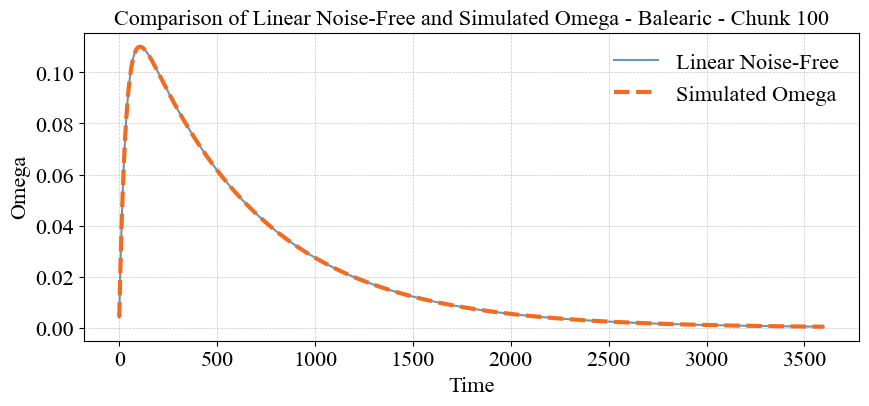

In [60]:
plt.rcParams['font.family'] = 'Times New Roman'
n = 99 

# Extract initial conditions consistently
initial_conditions = [balearic_ideal[n]['theta'].values[0], 
                      balearic_ideal[n]['omega'].values[0],0]

# Define time points for simulation
total_time = len(balearic_ideal[n]['omega'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original is available
omega_original = balearic_ideal[n]['omega'].values  # Replace 'omega' with the actual column name

# Simulate and plot results for a specific chunk (e.g., chunk n+1)
noiseless_simulate_sindy_model(balearic_models[n], initial_conditions, time_points, f'Balearic - Chunk {n+1}', omega_original)


##  LINEAR VALIDATION MODEL INCLUDING NOISE


In [61]:
import pandas as pd
from scipy.ndimage import gaussian_filter1d

def apply_gaussian_filter(data, chunk_size=900*4, sigma=60):
    # Create DataFrame
    data_df = pd.DataFrame({'omega': data})

    # Define the list to hold the filtered DataFrames
    filtered_data = []

    # Calculate the number of chunks needed
    num_chunks = len(data_df) // chunk_size

    # Split the DataFrame into chunks and apply the Gaussian filter to each chunk
    for j in range(num_chunks):
        # Extract the chunk
        chunk = data_df.iloc[j*chunk_size:(j+1)*chunk_size].copy()
        
        # Apply Gaussian filter to the 'omega' column
        chunk['omega_filtered'] = gaussian_filter1d(chunk['omega'], sigma=sigma)
        
        # Label the chunk with 'balearic'
        chunk['Region'] = 'balearic'
        
        # Append the filtered chunk to the list
        filtered_data.append(chunk)

    # If there are remaining data points
    if len(data_df) % chunk_size != 0:
        remaining_chunk = data_df.iloc[num_chunks*chunk_size:].copy()
        remaining_chunk['omega_filtered'] = gaussian_filter1d(remaining_chunk['omega'], sigma=sigma)
        
        # Label the remaining chunk with 'balearic'
        remaining_chunk['Region'] = 'balearic'
        
        # Append the remaining chunk to the list
        filtered_data.append(remaining_chunk)
    
    return filtered_data

In [62]:
def calculate_sindy_models(region_data, region_name):
    # Initialize an empty list for sindy_models
    sindy_models = []

    # Iterate over each chunk
    for chunk in region_data:
        # Integrate omega_filtered to get theta
        theta_chunk = integrate_data(chunk['omega_filtered'].values)

        # Stack normalized theta and omega_filtered
        stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))

        # Generate time values
        t_train_chunk = np.arange(0, len(stacked_data_chunk), 1)

        # Add time as a linear feature
        linear_time_feature_chunk = t_train_chunk.reshape(-1, 1)
        x_train_augmented_chunk = np.hstack([stacked_data_chunk, linear_time_feature_chunk])
        #x_train_augmented_chunk = np.hstack([stacked_data_chunk])

        # Feature names for SINDy (including a linear term for time)
        feature_names_chunk = ["theta", "omega", "time"]
        #feature_names_chunk = ["theta", "omega"]

        # Use Polynomial Library 
        polynomial_library_chunk = ps.PolynomialLibrary(degree=2)

        # Sparse regression optimizer
        sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-10)

        # Create a SINDy model with the polynomial library
        model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                               feature_library=polynomial_library_chunk,
                               optimizer=sparse_regression_optimizer_chunk)

        # Fit the SINDy model using the chunk data
        model_chunk.fit(x_train_augmented_chunk, t=1)

        # Append the SINDy model to the list
        sindy_models.append(model_chunk)

        # Print the learned model for the current chunk
        print(f"Model for {region_name} - Chunk {len(sindy_models)}:")
        model_chunk.print(precision=7)
        print("Model Score:", model_chunk.score(x_train_augmented_chunk, t=1))
        print()

    # Initialize empty lists for coefficient matrices
    coefficients_matrices = []

    # Iterate over each SINDy model in sindy_models
    for model in sindy_models:
        # Get the coefficients from the model
        coefficients = model.coefficients()

        # Append the coefficients to the list
        coefficients_matrices.append(coefficients)

    # Convert the list of matrices to a 3D NumPy array
    coefficients_array = np.array(coefficients_matrices)

    # Calculate mean and standard deviation along the first axis (axis=0) which corresponds to chunks
    mean_coefficients = np.mean(coefficients_array, axis=0)
    std_coefficients = np.std(coefficients_array, axis=0)

    # Print or use mean_coefficients and std_coefficients as needed
    print(f"Mean Coefficients for {region_name}:")
    print(mean_coefficients)
    print(f"Standard Deviation of Coefficients Coefficients for {region_name}:")
    print(std_coefficients)
    
    return sindy_models

In [63]:
def simulate_sindy_model(model, initial_conditions, time_points, title, omega_original, omega_filtered):
    # Simulate the system using the provided model
    simulated_data = model.simulate(initial_conditions, time_points)

    # Extract simulated theta and omega
    simulated_theta = simulated_data[:, 0]
    simulated_omega = simulated_data[:, 1]

    # Plot the simulation results
    plt.figure(figsize=(10, 6))

    # Plot the original Omega with noise
    plt.plot(omega_original, label='Original Omega with noise', alpha=0.7, color='#2b6a99')

    # Plot the Gaussian Filtered Omega
    plt.plot(omega_filtered, label='Gaussian Filtered Omega', linestyle='-', linewidth=2, color='#1b7c3d')

    # Plot the simulated Omega
    plt.plot(simulated_omega, label='Simulated Omega', linestyle='--', linewidth=3, color='#f16c23')

    plt.title(f'Comparison of Original, Filtered, and Simulated Omega - {title}')
    plt.xlabel('Time')
    plt.ylabel('Omega')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

In [64]:
def calculate_sindy_models_abs(region_data, region_name):
    # Initialize an empty list for sindy_models
    sindy_models = []

    # Iterate over each chunk
    for chunk in region_data:
        # Integrate omega_filtered to get theta
        theta_chunk = integrate_data(chunk['omega_filtered'].values)

        # Stack normalized theta and omega_filtered
        stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))

        # Generate time values
        t_train_chunk = np.arange(0, len(stacked_data_chunk), 1)

        # Add time as a linear feature
        linear_time_feature_chunk = t_train_chunk.reshape(-1, 1)
        x_train_augmented_chunk = np.hstack([stacked_data_chunk, linear_time_feature_chunk])

        # Feature names for SINDy (including a linear term for time)
        feature_names_chunk = ["theta", "omega", "time"]

        # Use Polynomial Library 
        polynomial_library_chunk = ps.PolynomialLibrary(degree=2)

        # Sparse regression optimizer
        sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-10)

        # Create a SINDy model with the polynomial library
        model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                               feature_library=polynomial_library_chunk,
                               optimizer=sparse_regression_optimizer_chunk)

        # Fit the SINDy model using the chunk data
        model_chunk.fit(x_train_augmented_chunk, t=1)

        # Append the SINDy model to the list
        sindy_models.append(model_chunk)

        # Print the learned model for the current chunk
        #print(f"Model for {region_name} - Chunk {len(sindy_models)}:")
        #model_chunk.print(precision=7)
        #print("Model Score:", model_chunk.score(x_train_augmented_chunk, t=1))
        #print()

    # Initialize empty lists for coefficient matrices
    coefficients_matrices = []
    
    for model in sindy_models:
        coefficients = model.coefficients()
        feature_names = model.get_feature_names()

        # Handling the presence of specific features
        time_indices = [feature_names.index(f) for f in feature_names if 'time' in f]

        # Take the absolute value of specific coefficients
        for idx in time_indices:
            coefficients[:, idx] = np.abs(coefficients[:, idx])

        coefficients_matrices.append(coefficients)

    # Convert to a 3D NumPy array and calculate mean and standard deviation
    coefficients_array = np.array(coefficients_matrices)
    mean_coefficients = np.mean(coefficients_array, axis=0)
    std_coefficients = np.std(coefficients_array, axis=0)

    print(f"Mean Coefficients for {region_name}:")
    print(mean_coefficients)
    print(f"Standard Deviation of Coefficients for {region_name}:")
    print(std_coefficients)

    return sindy_models


In [65]:
omega_Bal_noise_filtered = apply_gaussian_filter(omega_Bal_noise, sigma=60)
balearic_data = [chunk for chunk in omega_Bal_noise_filtered if chunk['Region'].iloc[0] == 'balearic']
noise_models = calculate_sindy_models_abs(balearic_data, 'Balearic')

Mean Coefficients for Balearic:
[[ 1.64043484e-05 -1.64755691e-05  9.99235553e-01  1.30063422e-06
   1.70055563e-09  3.44872359e-06  1.26914687e-08 -1.53753509e-04
   1.10696465e-06  1.97576149e-10]
 [ 3.21301692e-05 -3.35611562e-05 -1.28031938e-03  2.68828624e-06
   4.65138752e-09  6.06128602e-06  2.58451770e-08 -2.27979959e-04
   2.20327267e-06  4.23889763e-10]
 [ 1.00000000e+00  2.38009560e-18  9.18777862e-16  9.01628450e-18
  -3.29917698e-18 -4.11827764e-16  6.44442642e-19 -3.27238978e-14
   1.00741639e-16  1.03812071e-20]]
Standard Deviation of Coefficients for Balearic:
[[4.82967420e-04 2.43173125e-05 4.32812445e-03 1.03799178e-06
  3.51400258e-07 7.64514364e-05 1.15612532e-08 1.52448407e-02
  9.61037476e-07 1.81805932e-10]
 [9.61464244e-04 4.83315042e-05 8.71869697e-03 2.05510174e-06
  7.04975423e-07 1.53065343e-04 2.33669341e-08 3.06900635e-02
  1.94015481e-06 3.65932163e-10]
 [9.03296053e-15 2.88205019e-16 4.09323043e-14 1.38863114e-17
  7.96666895e-18 7.19635995e-16 1.3472287

In [ ]:
#['1', 'theta', 'omega','time',
# 'theta^2','theta omega','theta time','omega^2',
# 'omega time','time^2']

In [66]:
# for 'Balearic' region with noise
omega_Bal_noise_filtered = apply_gaussian_filter(omega_Bal_noise, sigma=60)
balearic_data = [chunk for chunk in omega_Bal_noise_filtered if chunk['Region'].iloc[0] == 'balearic']
balearic_models = calculate_sindy_models(balearic_data, 'Balearic')

Model for Balearic - Chunk 1:
(theta)' = 0.0003850 1 + -0.0000316 theta + 0.9968328 omega + 0.0000017 time + 0.0000002 theta^2 + 0.0000257 theta omega + 0.0084783 omega^2 + 0.0000005 omega time
(omega)' = 0.0007367 1 + -0.0000622 theta + -0.0060950 omega + 0.0000034 time + 0.0000004 theta^2 + 0.0000479 theta omega + 0.0168107 omega^2 + 0.0000010 omega time
(time)' = 1.0000000 1
Model Score: 0.47142923767834377

Model for Balearic - Chunk 2:
(theta)' = 0.0003901 1 + -0.0000390 theta + 0.9996671 omega + 0.0000024 time + 0.0000139 theta omega + -0.0031305 omega^2 + -0.0000005 omega time
(omega)' = 0.0007580 1 + -0.0000773 theta + -0.0005083 omega + 0.0000047 time + 0.0000262 theta omega + -0.0060913 omega^2 + -0.0000011 omega time
(time)' = 1.0000000 1
Model Score: 0.4396346837594442

Model for Balearic - Chunk 3:
(theta)' = 0.0006349 1 + -0.0000588 theta + 0.9946047 omega + 0.0000033 time + 0.0000006 theta^2 + 0.0000301 theta omega + 0.0243691 omega^2 + 0.0000008 omega time
(omega)' = 0.

Model for Balearic - Chunk 36:
(theta)' = -0.0001159 1 + -0.0000099 theta + 0.9957146 omega + -0.0000011 time + -0.0000281 theta omega + -0.0247302 omega^2 + 0.0000009 omega time
(omega)' = -0.0002184 1 + -0.0000195 theta + -0.0085247 omega + -0.0000023 time + -0.0000560 theta omega + -0.0497131 omega^2 + 0.0000018 omega time
(time)' = 1.0000000 1
Model Score: 0.5010989155441603

Model for Balearic - Chunk 37:
(theta)' = 0.0002990 1 + -0.0000335 theta + 0.9962301 omega + 0.0000013 time + 0.0000004 theta^2 + 0.0000493 theta omega + 0.0229134 omega^2 + -0.0000002 omega time
(omega)' = 0.0005845 1 + -0.0000666 theta + -0.0073156 omega + 0.0000027 time + 0.0000007 theta^2 + 0.0000961 theta omega + 0.0454449 omega^2 + -0.0000004 omega time
(time)' = 1.0000000 1
Model Score: 0.42034882997879314

Model for Balearic - Chunk 38:
(theta)' = 0.0008604 1 + -0.0000039 theta + 0.9924005 omega + -0.0000002 theta^2 + 0.0000947 theta omega + 0.0050599 omega^2 + 0.0000002 omega time
(omega)' = 0.0017133

Model for Balearic - Chunk 76:
(theta)' = 0.0003306 1 + -0.0000260 theta + 0.9974528 omega + 0.0000011 time + 0.0000003 theta^2 + 0.0000358 theta omega + -0.0019533 omega^2 + 0.0000002 omega time
(omega)' = 0.0006344 1 + -0.0000514 theta + -0.0048882 omega + 0.0000022 time + 0.0000006 theta^2 + 0.0000694 theta omega + -0.0040083 omega^2 + 0.0000003 omega time
(time)' = 1.0000000 1
Model Score: 0.42120113416941124

Model for Balearic - Chunk 77:
(theta)' = -0.0005289 1 + 0.0000169 theta + 1.0071351 omega + 0.0000010 time + -0.0000003 theta^2 + -0.0001149 theta omega + -0.0297016 omega^2 + 0.0000006 omega time
(omega)' = -0.0008971 1 + 0.0000191 theta + 0.0134075 omega + 0.0000022 time + -0.0000003 theta^2 + -0.0002120 theta omega + -0.0563982 omega^2 + 0.0000011 omega time
(time)' = 1.0000000 1
Model Score: 0.4624145728054468

Model for Balearic - Chunk 78:
(theta)' = 0.0002630 1 + 0.0000085 theta + 0.9951602 omega + -0.0000001 time + -0.0000001 theta^2 + 0.0000204 theta omega + 0.01295

Model for Balearic - Chunk 113:
(theta)' = 0.0015296 1 + -0.0000816 theta + 0.9930575 omega + 0.0000019 time + 0.0000007 theta^2 + 0.0002157 theta omega + -0.0066193 omega^2 + -0.0000038 omega time
(omega)' = 0.0030436 1 + -0.0001627 theta + -0.0138256 omega + 0.0000038 time + 0.0000015 theta^2 + 0.0004309 theta omega + -0.0000001 theta time + -0.0130713 omega^2 + -0.0000076 omega time
(time)' = 1.0000000 1
Model Score: 0.5344277553215026

Model for Balearic - Chunk 114:
(theta)' = -0.0000485 1 + -0.0000166 theta + 1.0018537 omega + 0.0000011 time + 0.0000003 theta^2 + -0.0000456 theta omega + -0.0066018 omega^2 + 0.0000001 omega time
(omega)' = -0.0002167 1 + -0.0000269 theta + 0.0030085 omega + 0.0000020 time + 0.0000006 theta^2 + -0.0001057 theta omega + -0.0030802 omega^2 + 0.0000007 omega time
(time)' = 1.0000000 1
Model Score: 0.3926069037902519

Model for Balearic - Chunk 115:
(theta)' = -0.0000985 1 + -0.0000024 theta + 1.0004282 omega + -0.0000001 time + 0.0000001 theta^2 + 0.

Model Score: 0.4716445974659383

Model for Balearic - Chunk 150:
(theta)' = -0.0000951 1 + -0.0000223 theta + 0.9995164 omega + 0.0000016 time + 0.0000002 theta^2 + 0.0000036 theta omega + 0.0027330 omega^2 + 0.0000001 omega time
(omega)' = -0.0001964 1 + -0.0000452 theta + -0.0008191 omega + 0.0000032 time + 0.0000004 theta^2 + 0.0000071 theta omega + 0.0054140 omega^2 + 0.0000001 omega time
(time)' = 1.0000000 1
Model Score: 0.45083902831770467

Model for Balearic - Chunk 151:
(theta)' = -0.0002201 1 + -0.0000409 theta + 0.9985719 omega + -0.0000025 time + -0.0000003 theta^2 + 0.0000158 theta omega + -0.0108317 omega^2 + 0.0000011 omega time
(omega)' = -0.0004322 1 + -0.0000818 theta + -0.0027498 omega + -0.0000050 time + -0.0000007 theta^2 + 0.0000328 theta omega + -0.0215516 omega^2 + 0.0000023 omega time
(time)' = 1.0000000 1
Model Score: 0.48109298721606314

Model for Balearic - Chunk 152:
(theta)' = -0.0000210 1 + -0.0000256 theta + 1.0021933 omega + -0.0000022 time + 0.0000152 

Model for Balearic - Chunk 185:
(theta)' = 0.0000016 1 + -0.0000072 theta + 0.9991219 omega + 0.0000013 time + -0.0000003 theta^2 + 0.0000088 theta omega + 0.0070045 omega^2 + 0.0000001 omega time
(omega)' = -0.0000227 1 + -0.0000137 theta + -0.0015246 omega + 0.0000026 time + -0.0000005 theta^2 + 0.0000157 theta omega + 0.0137288 omega^2 + 0.0000002 omega time
(time)' = 1.0000000 1
Model Score: 0.4734839187760198

Model for Balearic - Chunk 186:
(theta)' = 0.0001374 1 + 0.0000026 theta + 0.9954643 omega + 0.0000004 time + -0.0000003 theta^2 + -0.0000940 theta omega + 0.0392723 omega^2 + 0.0000049 omega time
(omega)' = 0.0002667 1 + 0.0000052 theta + -0.0089617 omega + 0.0000009 time + -0.0000006 theta^2 + -0.0001892 theta omega + 0.0784155 omega^2 + 0.0000099 omega time
(time)' = 1.0000000 1
Model Score: 0.4328602777429847

Model for Balearic - Chunk 187:
(theta)' = 0.0005665 1 + 0.0000135 theta + 1.0126584 omega + -0.0000017 time + 0.0000002 theta^2 + 0.0001955 theta omega + 0.047809

Model for Balearic - Chunk 224:
(theta)' = 0.0002055 1 + 0.0000084 theta + 0.9953545 omega + -0.0000003 time + 0.0000002 theta^2 + -0.0000647 theta omega + -0.0343221 omega^2 + -0.0000006 omega time
(omega)' = 0.0004111 1 + 0.0000168 theta + -0.0092716 omega + -0.0000005 time + 0.0000004 theta^2 + -0.0001280 theta omega + -0.0687242 omega^2 + -0.0000012 omega time
(time)' = 1.0000000 1
Model Score: 0.4281962143032927

Model for Balearic - Chunk 225:
(theta)' = -0.0000675 1 + -0.0000333 theta + 1.0008143 omega + -0.0000010 time + -0.0000003 theta^2 + 0.0000266 theta omega + 0.0090004 omega^2 + 0.0000004 omega time
(omega)' = -0.0001327 1 + -0.0000666 theta + 0.0016450 omega + -0.0000021 time + -0.0000005 theta^2 + 0.0000548 theta omega + 0.0174500 omega^2 + 0.0000008 omega time
(time)' = 1.0000000 1
Model Score: 0.48830575257522274

Model for Balearic - Chunk 226:
(theta)' = -0.0001802 1 + 0.0000031 theta + 0.9970907 omega + -0.0000005 time + 0.0000002 theta^2 + -0.0000219 theta omega +

Model for Balearic - Chunk 258:
(theta)' = -0.0000921 1 + -0.0000267 theta + 0.9924734 omega + 0.0000021 time + 0.0000293 theta omega + 0.0270226 omega^2 + 0.0000017 omega time
(omega)' = -0.0001876 1 + -0.0000536 theta + -0.0149609 omega + 0.0000042 time + 0.0000569 theta omega + 0.0543192 omega^2 + 0.0000034 omega time
(time)' = 1.0000000 1
Model Score: 0.4364239194539891

Model for Balearic - Chunk 259:
(theta)' = -0.0002187 1 + -0.0000201 theta + 0.9972104 omega + -0.0000008 time + -0.0000002 theta^2 + -0.0000426 theta omega + -0.0092633 omega^2 + 0.0000001 omega time
(omega)' = -0.0004183 1 + -0.0000396 theta + -0.0053671 omega + -0.0000017 time + -0.0000004 theta^2 + -0.0000825 theta omega + -0.0184873 omega^2 + 0.0000002 omega time
(time)' = 1.0000000 1
Model Score: 0.4129694070052548

Model for Balearic - Chunk 260:
(theta)' = -0.0000528 1 + -0.0000048 theta + 1.0004000 omega + -0.0000004 time + 0.0000101 theta omega + 0.0018090 omega^2
(omega)' = -0.0001886 1 + -0.0000149 thet

Model for Balearic - Chunk 294:
(theta)' = 0.0006421 1 + -0.0000708 theta + 0.9983240 omega + 0.0000026 time + 0.0000004 theta^2 + 0.0000007 theta omega + 0.0139203 omega^2 + 0.0000006 omega time
(omega)' = 0.0012762 1 + -0.0001412 theta + -0.0032847 omega + 0.0000051 time + 0.0000008 theta^2 + 0.0000009 theta omega + 0.0279004 omega^2 + 0.0000012 omega time
(time)' = 1.0000000 1
Model Score: 0.4741876859591459

Model for Balearic - Chunk 295:
(theta)' = -0.0004542 1 + -0.0000261 theta + 0.9993999 omega + -0.0000016 time + -0.0000001 theta^2 + 0.0000017 theta omega + 0.0039837 omega^2 + 0.0000005 omega time
(omega)' = -0.0008800 1 + -0.0000516 theta + -0.0010698 omega + -0.0000033 time + -0.0000002 theta^2 + 0.0000046 theta omega + 0.0079401 omega^2 + 0.0000010 omega time
(time)' = 1.0000000 1
Model Score: 0.46578374576060105

Model for Balearic - Chunk 296:
(theta)' = -0.0002047 1 + -0.0000559 theta + 0.9999888 omega + -0.0000018 time + -0.0000012 theta^2 + -0.0000259 theta omega + -0

Model Score: 0.49845629927463314

Model for Balearic - Chunk 314:
(theta)' = -0.0004477 1 + 0.0000081 theta + 1.0006658 omega + 0.0000011 time + -0.0000002 theta^2 + -0.0000438 theta omega + 0.0134159 omega^2 + 0.0000014 omega time
(omega)' = -0.0009265 1 + 0.0000166 theta + 0.0016325 omega + 0.0000022 time + -0.0000004 theta^2 + -0.0000892 theta omega + 0.0263155 omega^2 + 0.0000028 omega time
(time)' = 1.0000000 1
Model Score: 0.40792178974769966

Model for Balearic - Chunk 315:
(theta)' = 0.0006094 1 + -0.0000512 theta + 0.9900700 omega + 0.0000045 time + 0.0000003 theta^2 + 0.0000824 theta omega + 0.0279690 omega^2 + 0.0000012 omega time
(omega)' = 0.0012102 1 + -0.0001025 theta + -0.0197615 omega + 0.0000090 time + 0.0000005 theta^2 + 0.0001642 theta omega + -0.0000001 theta time + 0.0559537 omega^2 + 0.0000025 omega time
(time)' = 1.0000000 1
Model Score: 0.5520786252497812

Model for Balearic - Chunk 316:
(theta)' = 0.0001220 1 + -0.0000081 theta + 0.9984671 omega + 0.0000005 ti

Model for Balearic - Chunk 350:
(theta)' = 0.0001521 1 + -0.0000034 theta + 0.9983759 omega + 0.0000005 time + -0.0000001 theta^2 + -0.0000045 theta omega + -0.0008754 omega^2 + 0.0000011 omega time
(omega)' = 0.0002944 1 + -0.0000110 theta + -0.0029134 omega + 0.0000010 time + -0.0000123 theta omega + 0.0000197 omega^2 + 0.0000020 omega time
(time)' = 1.0000000 1
Model Score: 0.45951031946125714

Model for Balearic - Chunk 351:
(theta)' = 0.0001186 1 + -0.0000102 theta + 0.9999992 omega + 0.0000004 time + 0.0000001 theta^2 + 0.0000154 theta omega + -0.0079326 omega^2 + -0.0000006 omega time
(omega)' = -0.0000435 1 + -0.0000430 theta + 0.0024867 omega + 0.0000032 time + -0.0000281 theta omega + -0.0195656 omega^2 + 0.0000002 omega time
(time)' = 1.0000000 1
Model Score: 0.45924956663338284

Model for Balearic - Chunk 352:
(theta)' = 0.0002349 1 + -0.0000706 theta + 0.9967328 omega + 0.0000046 time + 0.0000005 theta^2 + 0.0000378 theta omega + 0.0124375 omega^2 + -0.0000003 omega time
(

Model Score: 0.47939191816809384

Model for Balearic - Chunk 370:
(theta)' = -0.0002858 1 + -0.0000335 theta + 1.0008443 omega + -0.0000016 time + 0.0000001 theta^2 + -0.0000145 theta omega + 0.0131908 omega^2 + -0.0000008 omega time
(omega)' = -0.0005594 1 + -0.0000664 theta + 0.0017659 omega + -0.0000031 time + 0.0000003 theta^2 + -0.0000260 theta omega + 0.0257730 omega^2 + -0.0000015 omega time
(time)' = 1.0000000 1
Model Score: 0.4693808358508978

Model for Balearic - Chunk 371:
(theta)' = -0.0003262 1 + 0.0000068 theta + 0.9972950 omega + 0.0000001 time + 0.0000003 theta^2 + -0.0000187 theta omega + 0.0034727 omega^2 + 0.0000006 omega time
(omega)' = -0.0006463 1 + 0.0000130 theta + -0.0053199 omega + 0.0000001 time + 0.0000006 theta^2 + -0.0000377 theta omega + 0.0068783 omega^2 + 0.0000012 omega time
(time)' = 1.0000000 1
Model Score: 0.41420363142895056

Model for Balearic - Chunk 372:
(theta)' = -0.0008966 1 + -0.0000173 theta + 0.9967814 omega + 0.0000002 time + -0.0000001 t

Model for Balearic - Chunk 405:
(theta)' = -0.0002450 1 + -0.0000172 theta + 0.9991435 omega + -0.0000006 time + -0.0000001 theta^2 + 0.0000167 theta omega + -0.0020485 omega^2 + 0.0000006 omega time
(omega)' = -0.0004270 1 + -0.0000417 theta + -0.0016153 omega + -0.0000015 time + -0.0000004 theta^2 + 0.0000357 theta omega + -0.0068858 omega^2 + 0.0000012 omega time
(time)' = 1.0000000 1
Model Score: 0.45720659199128616

Model for Balearic - Chunk 406:
(theta)' = 0.0001565 1 + 0.0000021 theta + 1.0028505 omega + -0.0000006 time + 0.0000548 theta omega + 0.0129628 omega^2 + 0.0000008 omega time
(omega)' = 0.0003274 1 + 0.0000044 theta + 0.0057712 omega + -0.0000012 time + 0.0000001 theta^2 + 0.0001095 theta omega + 0.0256501 omega^2 + 0.0000016 omega time
(time)' = 1.0000000 1
Model Score: 0.4121155881945893

Model for Balearic - Chunk 407:
(theta)' = 0.0002895 1 + -0.0000194 theta + 1.0039216 omega + -0.0000017 time + -0.0000003 theta^2 + 0.0001280 theta omega + -0.0029571 omega^2 + 0.

Model for Balearic - Chunk 442:
(theta)' = -0.0002376 1 + -0.0000337 theta + 0.9959361 omega + -0.0000018 time + -0.0000003 theta^2 + -0.0001000 theta omega + -0.0133943 omega^2 + -0.0000013 omega time
(omega)' = -0.0004605 1 + -0.0000674 theta + -0.0079257 omega + -0.0000036 time + -0.0000006 theta^2 + -0.0001958 theta omega + -0.0270233 omega^2 + -0.0000026 omega time
(time)' = 1.0000000 1
Model Score: 0.49865229615502943

Model for Balearic - Chunk 443:
(theta)' = 0.0000538 1 + -0.0000356 theta + 1.0034155 omega + -0.0000010 time + -0.0000010 theta^2 + 0.0004018 theta omega + -0.0094999 omega^2 + 0.0000071 omega time
(omega)' = 0.0001117 1 + -0.0000702 theta + 0.0069586 omega + -0.0000019 time + -0.0000019 theta^2 + 0.0008056 theta omega + -0.0000001 theta time + -0.0184866 omega^2 + 0.0000143 omega time
(time)' = 1.0000000 1
Model Score: 0.5187768880958631

Model for Balearic - Chunk 444:
(theta)' = -0.0004891 1 + -0.0000136 theta + 0.9960636 omega + -0.0000003 time + -0.0000433 th

Model for Balearic - Chunk 479:
(theta)' = -0.0007314 1 + -0.0000769 theta + 0.9937366 omega + -0.0000028 time + -0.0000010 theta^2 + -0.0000595 theta omega + -0.0239952 omega^2 + 0.0000009 omega time
(omega)' = -0.0014517 1 + -0.0001531 theta + -0.0125096 omega + -0.0000055 time + -0.0000020 theta^2 + -0.0001182 theta omega + -0.0000001 theta time + -0.0484826 omega^2 + 0.0000019 omega time
(time)' = 1.0000000 1
Model Score: 0.4860478742008061

Model for Balearic - Chunk 480:
(theta)' = 0.0001421 1 + -0.0000018 theta + 0.9983893 omega + -0.0000008 time + -0.0000097 theta omega + -0.0041644 omega^2 + 0.0000003 omega time
(omega)' = 0.0002787 1 + -0.0000043 theta + -0.0031253 omega + -0.0000015 time + -0.0000077 theta omega + -0.0092148 omega^2 + 0.0000009 omega time
(time)' = 1.0000000 1
Model Score: 0.4332019056609944

Model for Balearic - Chunk 481:
(theta)' = 0.0005473 1 + -0.0000198 theta + 0.9989061 omega + 0.0000004 time + 0.0000002 theta^2 + 0.0000060 theta omega + -0.0014785 om

Model for Balearic - Chunk 515:
(theta)' = -0.0000172 1 + -0.0000337 theta + 1.0002864 omega + -0.0000028 time + -0.0000002 theta^2 + 0.0000377 theta omega + -0.0084783 omega^2 + 0.0000011 omega time
(omega)' = -0.0000314 1 + -0.0000674 theta + 0.0005599 omega + -0.0000055 time + -0.0000003 theta^2 + 0.0000749 theta omega + -0.0173593 omega^2 + 0.0000023 omega time
(time)' = 1.0000000 1
Model Score: 0.4767785793214166

Model for Balearic - Chunk 516:
(theta)' = -0.0010070 1 + -0.0000169 theta + 0.9958053 omega + -0.0000005 time + -0.0000612 theta omega + 0.0129873 omega^2 + -0.0000010 omega time
(omega)' = -0.0020109 1 + -0.0000369 theta + -0.0085383 omega + -0.0000012 time + -0.0000001 theta^2 + -0.0001214 theta omega + 0.0235166 omega^2 + -0.0000018 omega time
(time)' = 1.0000000 1
Model Score: 0.42351928230036817

Model for Balearic - Chunk 517:
(theta)' = 0.0000713 1 + -0.0000079 theta + 1.0028906 omega + 0.0000006 time + -0.0000502 theta omega + -0.0196949 omega^2 + 0.0000006 omeg

Model Score: 0.45333952160841967

Model for Balearic - Chunk 553:
(theta)' = -0.0008083 1 + -0.0000279 theta + 1.0024318 omega + 0.0000048 time + 0.0000003 theta^2 + -0.0000597 theta omega + 0.0272657 omega^2 + 0.0000008 omega time
(omega)' = -0.0016253 1 + -0.0000557 theta + 0.0049284 omega + 0.0000096 time + 0.0000007 theta^2 + -0.0001202 theta omega + -0.0000001 theta time + 0.0544633 omega^2 + 0.0000017 omega time
(time)' = 1.0000000 1
Model Score: 0.5375804747525432

Model for Balearic - Chunk 554:
(theta)' = -0.0008716 1 + 0.0000221 theta + 1.0066048 omega + 0.0000002 time + -0.0001132 theta omega + -0.0115661 omega^2 + 0.0000007 omega time
(omega)' = -0.0017490 1 + 0.0000441 theta + 0.0132672 omega + 0.0000003 time + -0.0000001 theta^2 + -0.0002247 theta omega + -0.0232550 omega^2 + 0.0000013 omega time
(time)' = 1.0000000 1
Model Score: 0.38884221948165987

Model for Balearic - Chunk 555:
(theta)' = 0.0002903 1 + -0.0000033 theta + 1.0072472 omega + 0.0000013 time + -0.0000001 

Model for Balearic - Chunk 589:
(theta)' = -0.0011344 1 + -0.0000053 theta + 1.0076563 omega + 0.0000021 time + 0.0000002 theta^2 + -0.0001183 theta omega + 0.0090293 omega^2 + 0.0000006 omega time
(omega)' = -0.0022895 1 + -0.0000103 theta + 0.0154705 omega + 0.0000043 time + 0.0000004 theta^2 + -0.0002381 theta omega + -0.0000001 theta time + 0.0178710 omega^2 + 0.0000012 omega time
(time)' = 1.0000000 1
Model Score: 0.4564741231710132

Model for Balearic - Chunk 590:
(theta)' = 0.0008156 1 + -0.0000374 theta + 1.0005330 omega + 0.0000020 time + -0.0000001 theta^2 + 0.0000649 theta omega + -0.0238965 omega^2 + -0.0000029 omega time
(omega)' = 0.0016222 1 + -0.0000746 theta + 0.0012083 omega + 0.0000039 time + -0.0000002 theta^2 + 0.0001293 theta omega + -0.0483113 omega^2 + -0.0000059 omega time
(time)' = 1.0000000 1
Model Score: 0.46583518068593416

Model for Balearic - Chunk 591:
(theta)' = 0.0006821 1 + -0.0000188 theta + 0.9984070 omega + 0.0000007 time + 0.0000002 theta^2 + -0.0

Model for Balearic - Chunk 609:
(theta)' = -0.0004313 1 + -0.0000256 theta + 0.9953763 omega + -0.0000010 time + -0.0000004 theta^2 + -0.0000747 theta omega + -0.0029793 omega^2
(omega)' = -0.0008536 1 + -0.0000512 theta + -0.0091923 omega + -0.0000019 time + -0.0000007 theta^2 + -0.0001499 theta omega + -0.0061476 omega^2 + -0.0000001 omega time
(time)' = 1.0000000 1
Model Score: 0.4483754117714702

Model for Balearic - Chunk 610:
(theta)' = -0.0001996 1 + 0.0000018 theta + 0.9953272 omega + 0.0000001 time + 0.0000001 theta^2 + -0.0000344 theta omega + -0.0124030 omega^2 + 0.0000010 omega time
(omega)' = -0.0001554 1 + -0.0000192 theta + -0.0025457 omega + -0.0000016 time + -0.0000696 theta omega + 0.0005235 omega^2 + -0.0000014 omega time
(time)' = 1.0000000 1
Model Score: 0.4095058199270754

Model for Balearic - Chunk 611:
(theta)' = 0.0011250 1 + 0.0000002 theta + 1.0071971 omega + -0.0000036 time + 0.0000920 theta omega + 0.0135409 omega^2 + 0.0000011 omega time
(omega)' = 0.00223

Model for Balearic - Chunk 629:
(theta)' = -0.0010817 1 + 0.0000327 theta + 1.0019409 omega + 0.0000001 time + -0.0000003 theta^2 + -0.0000583 theta omega + 0.0079789 omega^2 + 0.0000014 omega time
(omega)' = -0.0022518 1 + 0.0000673 theta + 0.0043855 omega + 0.0000003 time + -0.0000006 theta^2 + -0.0001224 theta omega + 0.0156437 omega^2 + 0.0000029 omega time
(time)' = 1.0000000 1
Model Score: 0.4148995105091779

Model for Balearic - Chunk 630:
(theta)' = 0.0003734 1 + -0.0000215 theta + 1.0005466 omega + 0.0000011 time + -0.0000158 theta omega + -0.0106904 omega^2 + 0.0000007 omega time
(omega)' = 0.0007203 1 + -0.0000420 theta + 0.0012220 omega + 0.0000022 time + -0.0000326 theta omega + -0.0211820 omega^2 + 0.0000015 omega time
(time)' = 1.0000000 1
Model Score: 0.4609555846462065

Model for Balearic - Chunk 631:
(theta)' = 0.0002192 1 + -0.0000009 theta + 1.0034027 omega + -0.0000027 time + 0.0000002 theta^2 + 0.0000669 theta omega + 0.0113352 omega^2 + 0.0000018 omega time
(omeg

Model for Balearic - Chunk 649:
(theta)' = 0.0006533 1 + -0.0000262 theta + 0.9936041 omega + 0.0000008 time + 0.0000001 theta^2 + 0.0001247 theta omega + 0.0104041 omega^2 + -0.0000014 omega time
(omega)' = 0.0012714 1 + -0.0000600 theta + -0.0122184 omega + 0.0000018 time + 0.0000005 theta^2 + 0.0002442 theta omega + 0.0233259 omega^2 + -0.0000028 omega time
(time)' = 1.0000000 1
Model Score: 0.44074540689982283

Model for Balearic - Chunk 650:
(theta)' = 0.0001923 1 + -0.0000235 theta + 1.0006396 omega + 0.0000012 time + 0.0000004 theta^2 + -0.0000223 theta omega + -0.0035919 omega^2 + 0.0000002 omega time
(omega)' = 0.0003805 1 + -0.0000471 theta + 0.0013040 omega + 0.0000023 time + 0.0000007 theta^2 + -0.0000439 theta omega + -0.0070241 omega^2 + 0.0000003 omega time
(time)' = 1.0000000 1
Model Score: 0.4015724546752857

Model for Balearic - Chunk 651:
(theta)' = 0.0000341 1 + -0.0000241 theta + 1.0053815 omega + 0.0000022 time + 0.0000001 theta^2 + -0.0000625 theta omega + -0.023

Model Score: 0.4814691897238128

Model for Balearic - Chunk 686:
(theta)' = 0.0000720 1 + -0.0000127 theta + 1.0021003 omega + 0.0000003 time + 0.0000002 theta^2 + -0.0000591 theta omega + 0.0002290 omega^2 + 0.0000002 omega time
(omega)' = -0.0000470 1 + -0.0000163 theta + 0.0059697 omega + 0.0000007 time + 0.0000002 theta^2 + -0.0001399 theta omega + -0.0033758 omega^2 + 0.0000003 omega time
(time)' = 1.0000000 1
Model Score: 0.42660452429571594

Model for Balearic - Chunk 687:
(theta)' = -0.0010475 1 + -0.0000018 theta + 1.0107198 omega + 0.0000026 time + -0.0000871 theta omega + -0.0230968 omega^2 + -0.0000013 omega time
(omega)' = -0.0021352 1 + -0.0000030 theta + 0.0217570 omega + 0.0000052 time + -0.0001774 theta omega + -0.0465227 omega^2 + -0.0000025 omega time
(time)' = 1.0000000 1
Model Score: 0.48893898063541

Model for Balearic - Chunk 688:
(theta)' = 0.0003692 1 + -0.0000284 theta + 0.9977019 omega + 0.0000022 time + 0.0000001 theta^2 + 0.0000280 theta omega + 0.0018075 o

In [84]:
c_2_model2

{'Balearic': array([-4.51579245e-05]),
 'Irish': array([-6.34585943e-07]),
 'Iceland': array([-0.])}

In [85]:
c_1_model2

{'Balearic': array([-0.0295151]),
 'Irish': array([-0.023064]),
 'Iceland': array([-0.00964162])}

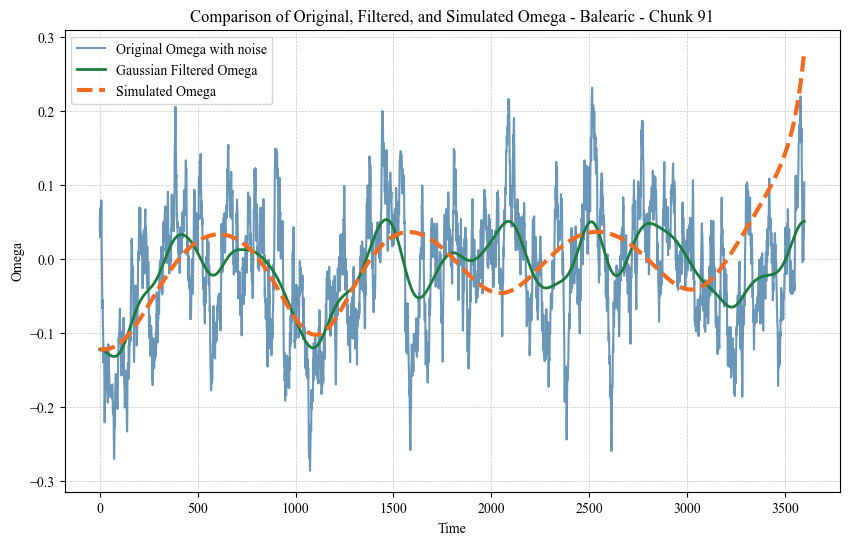

In [52]:
n=90
# Assume that 'omega_filtered' is the variable you want to integrate
initial_conditions = [integrate_data(balearic_data[n]['omega_filtered'].values)[0], 
                      balearic_data[n]['omega_filtered'].iloc[0],0]

# Define time points for simulation
total_time = len(balearic_data[1]['omega_filtered'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original and omega_filtered are available
omega_original = balearic_data[n]['omega'].values  # Replace 'omega' with the actual column name
omega_filtered = balearic_data[n]['omega_filtered'].values

# Simulate and plot results for a specific chunk (e.g., chunk 2)
simulate_sindy_model(balearic_models[n], initial_conditions, time_points, f'Balearic - Chunk {n+1}', omega_original, omega_filtered)


## LINEAR VALIDATION MODEL WITH NOISE AND TIME-DEPENDENT DRIVING

In [67]:
# for 'Balearic' region with noise
omega_Bal_time_filtered = apply_gaussian_filter(omega_Bal_time, sigma=60)
balearic_data = [chunk for chunk in omega_Bal_time_filtered if chunk['Region'].iloc[0] == 'balearic']
time_models = calculate_sindy_models_abs(balearic_data, 'Balearic')

Mean Coefficients for Balearic:
[[-2.08744521e-05 -1.40275450e-05  9.99376313e-01  7.66796418e-07
   7.53536798e-09 -4.73408925e-06  9.26514842e-09 -8.03690677e-04
   1.12289520e-06  2.40772787e-10]
 [-4.06452109e-05 -3.05449193e-05 -1.01640783e-03  1.65595142e-06
   2.28319316e-08 -9.96126664e-06  1.89803819e-08 -1.72327448e-03
   2.20118527e-06  5.19435725e-10]
 [ 1.00000000e+00  3.94497386e-18 -1.32671820e-15  7.30891107e-18
  -2.01171880e-18 -3.30851334e-16  9.36407425e-19 -2.58420960e-14
   1.03950535e-16  1.05684567e-20]]
Standard Deviation of Coefficients for Balearic:
[[3.87930047e-04 2.36233322e-05 3.73475144e-03 6.69998572e-07
  4.50655795e-07 8.81884854e-05 1.02570505e-08 1.60467754e-02
  1.09442941e-06 1.98551842e-10]
 [7.65999425e-04 4.73776174e-05 7.43308107e-03 1.35837911e-06
  9.20030102e-07 1.75964216e-04 2.05761757e-08 3.19389821e-02
  2.17220514e-06 3.92459717e-10]
 [8.28257257e-15 4.41984410e-16 3.68762595e-14 1.45604497e-17
  5.44209135e-17 7.58524645e-16 2.3453788

In [68]:
balearic_models = calculate_sindy_models(balearic_data, 'Balearic')

Model for Balearic - Chunk 1:
(theta)' = -0.0001442 1 + -0.0000160 theta + 1.0004260 omega + -0.0000004 time + 0.0000001 theta^2 + -0.0000199 theta omega + 0.0255486 omega^2 + -0.0000007 omega time
(omega)' = -0.0002823 1 + -0.0000319 theta + 0.0009815 omega + -0.0000008 time + 0.0000001 theta^2 + -0.0000390 theta omega + 0.0512772 omega^2 + -0.0000014 omega time
(time)' = 1.0000000 1
Model Score: 0.4134749570678428

Model for Balearic - Chunk 2:
(theta)' = -0.0006846 1 + -0.0000211 theta + 0.9943795 omega + -0.0001111 theta omega + -0.0056225 omega^2 + 0.0000009 omega time
(omega)' = -0.0013571 1 + -0.0000422 theta + -0.0110766 omega + -0.0000001 time + -0.0002214 theta omega + -0.0111394 omega^2 + 0.0000018 omega time
(time)' = 1.0000000 1
Model Score: 0.42803053274332575

Model for Balearic - Chunk 3:
(theta)' = -0.0003820 1 + -0.0000026 theta + 0.9995087 omega + 0.0000001 time + 0.0000002 theta^2 + 0.0000309 theta omega + 0.0034634 omega^2 + 0.0000008 omega time
(omega)' = -0.00022

Model for Balearic - Chunk 38:
(theta)' = -0.0000594 1 + 0.0000227 theta + 0.9939958 omega + -0.0000005 time + 0.0000006 theta^2 + -0.0001111 theta omega + 0.0032579 omega^2 + 0.0000015 omega time
(omega)' = -0.0001207 1 + 0.0000446 theta + -0.0120252 omega + -0.0000010 time + 0.0000011 theta^2 + -0.0002247 theta omega + 0.0061703 omega^2 + 0.0000030 omega time
(time)' = 1.0000000 1
Model Score: 0.4654719647879251

Model for Balearic - Chunk 39:
(theta)' = -0.0000106 1 + -0.0000125 theta + 1.0002122 omega + -0.0000001 time + -0.0000003 theta^2 + -0.0000135 theta omega + -0.0006296 omega^2 + -0.0000003 omega time
(omega)' = -0.0000208 1 + -0.0000250 theta + 0.0004637 omega + -0.0000002 time + -0.0000007 theta^2 + -0.0000256 theta omega + -0.0012662 omega^2 + -0.0000006 omega time
(time)' = 1.0000000 1
Model Score: 0.45361589630759536

Model for Balearic - Chunk 40:
(theta)' = -0.0002706 1 + -0.0000106 theta + 0.9977264 omega + 0.0000001 theta^2 + -0.0000542 theta omega + 0.0010006 omega

Model for Balearic - Chunk 74:
(theta)' = -0.0005957 1 + -0.0000183 theta + 0.9932847 omega + -0.0000007 time + -0.0000001 theta^2 + -0.0000519 theta omega + -0.0167138 omega^2 + 0.0000019 omega time
(omega)' = -0.0011828 1 + -0.0000368 theta + -0.0133804 omega + -0.0000014 time + -0.0000002 theta^2 + -0.0001042 theta omega + -0.0338199 omega^2 + 0.0000038 omega time
(time)' = 1.0000000 1
Model Score: 0.46634251388693615

Model for Balearic - Chunk 75:
(theta)' = -0.0000750 1 + 0.0000177 theta + 0.9998995 omega + -0.0000003 time + 0.0000006 theta^2 + 0.0000507 theta omega + 0.0099054 omega^2 + -0.0000001 omega time
(omega)' = -0.0001473 1 + 0.0000354 theta + -0.0001736 omega + -0.0000005 time + 0.0000012 theta^2 + 0.0001002 theta omega + 0.0198971 omega^2 + -0.0000002 omega time
(time)' = 1.0000000 1
Model Score: 0.4122236325909749

Model for Balearic - Chunk 76:
(theta)' = -0.0004734 1 + 0.0000065 theta + 0.9945599 omega + -0.0000003 time + 0.0000007 theta^2 + -0.0001244 theta omega +

Model for Balearic - Chunk 111:
(theta)' = -0.0001917 1 + -0.0000169 theta + 0.9984729 omega + -0.0000007 time + -0.0000001 theta^2 + -0.0000390 theta omega + 0.0032980 omega^2 + 0.0000002 omega time
(omega)' = -0.0003800 1 + -0.0000342 theta + -0.0029650 omega + -0.0000014 time + -0.0000001 theta^2 + -0.0000777 theta omega + 0.0066001 omega^2 + 0.0000004 omega time
(time)' = 1.0000000 1
Model Score: 0.4608426504402244

Model for Balearic - Chunk 112:
(theta)' = -0.0009037 1 + -0.0000338 theta + 0.9918206 omega + -0.0000003 time + -0.0000001 theta^2 + -0.0001013 theta omega + -0.0163483 omega^2 + 0.0000036 omega time
(omega)' = -0.0017846 1 + -0.0000671 theta + -0.0162435 omega + -0.0000005 time + -0.0000003 theta^2 + -0.0002023 theta omega + -0.0328968 omega^2 + 0.0000072 omega time
(time)' = 1.0000000 1
Model Score: 0.3913620626150777

Model for Balearic - Chunk 113:
(theta)' = -0.0000352 1 + -0.0000140 theta + 1.0005368 omega + -0.0000006 time + 0.0000669 theta omega + -0.0027667 om

Model Score: 0.4906783932911967

Model for Balearic - Chunk 149:
(theta)' = -0.0002345 1 + -0.0000494 theta + 0.9991112 omega + -0.0000007 time + -0.0000004 theta^2 + -0.0000076 theta omega + 0.0028664 omega^2 + 0.0000003 omega time
(omega)' = -0.0004661 1 + -0.0000987 theta + -0.0016968 omega + -0.0000014 time + -0.0000008 theta^2 + -0.0000151 theta omega + 0.0060435 omega^2 + 0.0000005 omega time
(time)' = 1.0000000 1
Model Score: 0.4633393693460765

Model for Balearic - Chunk 150:
(theta)' = 0.0001192 1 + -0.0000172 theta + 1.0016308 omega + -0.0000011 time + -0.0000003 theta^2 + 0.0001220 theta omega + -0.0130880 omega^2 + 0.0000003 omega time
(omega)' = 0.0002463 1 + -0.0000344 theta + 0.0034230 omega + -0.0000022 time + -0.0000006 theta^2 + 0.0002462 theta omega + -0.0262529 omega^2 + 0.0000005 omega time
(time)' = 1.0000000 1
Model Score: 0.42915399327775683

Model for Balearic - Chunk 151:
(theta)' = 0.0000071 1 + -0.0000142 theta + 0.9986186 omega + 0.0000009 time + -0.0000001

Model for Balearic - Chunk 186:
(theta)' = -0.0001174 1 + -0.0000146 theta + 1.0021316 omega + -0.0000011 time + 0.0000299 theta omega + 0.0145620 omega^2 + -0.0000007 omega time
(omega)' = -0.0002134 1 + -0.0000288 theta + 0.0044654 omega + -0.0000022 time + 0.0000619 theta omega + 0.0292105 omega^2 + -0.0000015 omega time
(time)' = 1.0000000 1
Model Score: 0.47888594055280015

Model for Balearic - Chunk 187:
(theta)' = 0.0001634 1 + -0.0000150 theta + 1.0028108 omega + -0.0000002 time + -0.0000003 theta^2 + -0.0003132 theta omega + -0.0220647 omega^2 + -0.0000048 omega time
(omega)' = 0.0003438 1 + -0.0000392 theta + 0.0055390 omega + -0.0000006 time + -0.0000002 theta^2 + -0.0006229 theta omega + -0.0385426 omega^2 + -0.0000095 omega time
(time)' = 1.0000000 1
Model Score: 0.45622130586791504

Model for Balearic - Chunk 188:
(theta)' = 0.0003804 1 + -0.0000220 theta + 0.9995592 omega + 0.0000004 time + 0.0000002 theta^2 + -0.0000070 theta omega + -0.0079361 omega^2
(omega)' = 0.0007

Model for Balearic - Chunk 206:
(theta)' = -0.0003035 1 + -0.0000302 theta + 0.9941104 omega + -0.0000005 time + -0.0000003 theta^2 + -0.0001091 theta omega + -0.0170987 omega^2 + 0.0000023 omega time
(omega)' = -0.0006006 1 + -0.0000607 theta + -0.0115968 omega + -0.0000011 time + -0.0000007 theta^2 + -0.0002174 theta omega + -0.0344858 omega^2 + 0.0000045 omega time
(time)' = 1.0000000 1
Model Score: 0.4438992547560589

Model for Balearic - Chunk 207:
(theta)' = 0.0001855 1 + 0.0000006 theta + 0.9990854 omega + -0.0000013 time + -0.0000019 theta omega + 0.0063108 omega^2 + 0.0000001 omega time
(omega)' = 0.0003753 1 + 0.0000004 theta + -0.0016737 omega + -0.0000025 time + 0.0000001 theta^2 + -0.0000035 theta omega + 0.0125770 omega^2 + 0.0000001 omega time
(time)' = 1.0000000 1
Model Score: 0.44470359966761014

Model for Balearic - Chunk 208:
(theta)' = -0.0003929 1 + 0.0000172 theta + 0.9957112 omega + 0.0000001 time + 0.0000006 theta^2 + -0.0000366 theta omega + 0.0088329 omega^2 +

Model for Balearic - Chunk 244:
(theta)' = -0.0006880 1 + -0.0000256 theta + 0.9937151 omega + -0.0000002 time + 0.0000001 theta^2 + -0.0001363 theta omega + 0.0014069 omega^2 + 0.0000022 omega time
(omega)' = -0.0013561 1 + -0.0000506 theta + -0.0124956 omega + -0.0000004 time + 0.0000001 theta^2 + -0.0002719 theta omega + 0.0022161 omega^2 + 0.0000045 omega time
(time)' = 1.0000000 1
Model Score: 0.4453498451712705

Model for Balearic - Chunk 245:
(theta)' = 0.0005987 1 + 0.0000073 theta + 1.0041157 omega + -0.0000022 time + 0.0000002 theta^2 + 0.0000444 theta omega + 0.0165089 omega^2 + -0.0000012 omega time
(omega)' = 0.0012176 1 + 0.0000147 theta + 0.0084453 omega + -0.0000044 time + 0.0000004 theta^2 + 0.0000901 theta omega + 0.0333799 omega^2 + -0.0000025 omega time
(time)' = 1.0000000 1
Model Score: 0.47359960201030527

Model for Balearic - Chunk 246:
(theta)' = 0.0001426 1 + -0.0000465 theta + 0.9969091 omega + -0.0000022 time + -0.0000004 theta^2 + -0.0000015 theta omega + -0

Model Score: 0.39132545647648537

Model for Balearic - Chunk 264:
(theta)' = -0.0001583 1 + -0.0000108 theta + 0.9984653 omega + 0.0000011 time + 0.0000112 theta omega + 0.0024925 omega^2 + 0.0000007 omega time
(omega)' = -0.0003178 1 + -0.0000226 theta + -0.0030261 omega + 0.0000023 time + 0.0000229 theta omega + 0.0056798 omega^2 + 0.0000014 omega time
(time)' = 1.0000000 1
Model Score: 0.4620729969710798

Model for Balearic - Chunk 265:
(theta)' = 0.0000515 1 + -0.0000045 theta + 1.0008530 omega + -0.0000003 time + 0.0000003 theta^2 + -0.0000041 theta omega + 0.0019494 omega^2 + -0.0000005 omega time
(omega)' = 0.0001045 1 + -0.0000090 theta + 0.0018110 omega + -0.0000007 time + 0.0000007 theta^2 + -0.0000069 theta omega + 0.0039542 omega^2 + -0.0000011 omega time
(time)' = 1.0000000 1
Model Score: 0.42592691925011533

Model for Balearic - Chunk 266:
(theta)' = -0.0004706 1 + -0.0000140 theta + 0.9967658 omega + -0.0000004 time + -0.0000327 theta omega + 0.0024944 omega^2 + 0.000001

Model for Balearic - Chunk 303:
(theta)' = -0.0001728 1 + -0.0000247 theta + 1.0009336 omega + -0.0000006 time + -0.0000001 theta^2 + 0.0000126 theta omega + 0.0265466 omega^2 + -0.0000006 omega time
(omega)' = -0.0003424 1 + -0.0000494 theta + 0.0019094 omega + -0.0000011 time + -0.0000002 theta^2 + 0.0000232 theta omega + 0.0531140 omega^2 + -0.0000013 omega time
(time)' = 1.0000000 1
Model Score: 0.43459701791375444

Model for Balearic - Chunk 304:
(theta)' = 0.0002908 1 + -0.0000147 theta + 1.0045949 omega + -0.0000013 time + -0.0000001 theta^2 + 0.0000733 theta omega + -0.0064409 omega^2 + -0.0000013 omega time
(omega)' = 0.0005827 1 + -0.0000295 theta + 0.0092607 omega + -0.0000026 time + -0.0000001 theta^2 + 0.0001466 theta omega + -0.0119119 omega^2 + -0.0000025 omega time
(time)' = 1.0000000 1
Model Score: 0.4492212983385207

Model for Balearic - Chunk 305:
(theta)' = -0.0004765 1 + -0.0000286 theta + 1.0006840 omega + -0.0000014 time + -0.0000001 theta^2 + 0.0000159 theta ome

Model for Balearic - Chunk 336:
(theta)' = 0.0002238 1 + -0.0000142 theta + 0.9974870 omega + 0.0000001 time + 0.0000002 theta^2 + 0.0000374 theta omega + 0.0055684 omega^2 + 0.0000009 omega time
(omega)' = 0.0004389 1 + -0.0000283 theta + -0.0049008 omega + 0.0000003 time + 0.0000004 theta^2 + 0.0000751 theta omega + 0.0106804 omega^2 + 0.0000018 omega time
(time)' = 1.0000000 1
Model Score: 0.40459310174604957

Model for Balearic - Chunk 337:
(theta)' = 0.0003805 1 + 0.0000380 theta + 0.9980644 omega + -0.0000010 time + 0.0000006 theta^2 + -0.0000320 theta omega + -0.0174491 omega^2 + 0.0000019 omega time
(omega)' = 0.0007603 1 + 0.0000759 theta + -0.0038557 omega + -0.0000020 time + 0.0000013 theta^2 + -0.0000657 theta omega + -0.0000001 theta time + -0.0351376 omega^2 + 0.0000038 omega time
(time)' = 1.0000000 1
Model Score: 0.4369208192603981

Model for Balearic - Chunk 338:
(theta)' = -0.0003001 1 + -0.0000133 theta + 0.9994247 omega + -0.0000003 time + 0.0000081 theta omega + 0.

Model Score: 0.44372790111128807

Model for Balearic - Chunk 374:
(theta)' = -0.0001624 1 + -0.0000501 theta + 1.0039462 omega + -0.0000016 time + -0.0000008 theta^2 + 0.0000707 theta omega + 0.0184180 omega^2 + -0.0000012 omega time
(omega)' = -0.0003118 1 + -0.0000998 theta + 0.0080343 omega + -0.0000032 time + -0.0000017 theta^2 + 0.0001442 theta omega + 0.0365949 omega^2 + -0.0000025 omega time
(time)' = 1.0000000 1
Model Score: 0.5066481603999832

Model for Balearic - Chunk 375:
(theta)' = -0.0001137 1 + -0.0000293 theta + 0.9984583 omega + -0.0000014 time + -0.0000002 theta^2 + -0.0000197 theta omega + -0.0108155 omega^2 + 0.0000009 omega time
(omega)' = -0.0002279 1 + -0.0000587 theta + -0.0030805 omega + -0.0000028 time + -0.0000003 theta^2 + -0.0000404 theta omega + -0.0217680 omega^2 + 0.0000018 omega time
(time)' = 1.0000000 1
Model Score: 0.49014067744148254

Model for Balearic - Chunk 376:
(theta)' = -0.0003703 1 + 0.0000009 theta + 0.9928867 omega + 0.0000002 time + 0.000

Model for Balearic - Chunk 395:
(theta)' = -0.0000841 1 + 0.0000722 theta + 0.9989376 omega + 0.0000001 time + -0.0000034 theta^2 + -0.0001054 theta omega + 0.0159021 omega^2 + 0.0000010 omega time
(omega)' = -0.0001185 1 + 0.0001533 theta + -0.0037222 omega + 0.0000001 time + -0.0000071 theta^2 + -0.0001489 theta omega + -0.0000001 theta time + 0.0326751 omega^2 + 0.0000026 omega time
(time)' = 1.0000000 1
Model Score: 0.47683666238477973

Model for Balearic - Chunk 396:
(theta)' = 0.0002688 1 + -0.0000244 theta + 0.9963489 omega + 0.0000008 time + 0.0000003 theta^2 + 0.0000210 theta omega + 0.0231193 omega^2 + 0.0000013 omega time
(omega)' = 0.0005319 1 + -0.0000487 theta + -0.0071859 omega + 0.0000015 time + 0.0000006 theta^2 + 0.0000407 theta omega + 0.0462005 omega^2 + 0.0000027 omega time
(time)' = 1.0000000 1
Model Score: 0.4707776253155472

Model for Balearic - Chunk 397:
(theta)' = 0.0000741 1 + -0.0000485 theta + 0.9989786 omega + -0.0000010 time + -0.0000005 theta^2 + 0.0000

Model for Balearic - Chunk 415:
(theta)' = -0.0001851 1 + 0.0000093 theta + 1.0018848 omega + 0.0000008 time + -0.0000004 theta^2 + -0.0000828 theta omega + -0.0097169 omega^2 + -0.0000013 omega time
(omega)' = -0.0003877 1 + 0.0000192 theta + 0.0039732 omega + 0.0000017 time + -0.0000007 theta^2 + -0.0001679 theta omega + -0.0194861 omega^2 + -0.0000027 omega time
(time)' = 1.0000000 1
Model Score: 0.41966635935186475

Model for Balearic - Chunk 416:
(theta)' = 0.0003429 1 + -0.0000277 theta + 0.9993035 omega + 0.0000004 time + 0.0000001 theta^2 + 0.0000262 theta omega + -0.0061662 omega^2 + 0.0000002 omega time
(omega)' = 0.0006817 1 + -0.0000554 theta + -0.0013846 omega + 0.0000008 time + 0.0000002 theta^2 + 0.0000531 theta omega + -0.0117532 omega^2 + 0.0000004 omega time
(time)' = 1.0000000 1
Model Score: 0.42440069477727144

Model for Balearic - Chunk 417:
(theta)' = 0.0000372 1 + -0.0000040 theta + 1.0013969 omega + 0.0000006 time + -0.0000002 theta^2 + -0.0000575 theta omega + 

Model for Balearic - Chunk 453:
(theta)' = 0.0000164 1 + -0.0000011 theta + 0.9992305 omega + 0.0000004 time + -0.0000001 theta^2 + 0.0000178 theta omega + -0.0049272 omega^2 + 0.0000002 omega time
(omega)' = 0.0000322 1 + -0.0000024 theta + -0.0015376 omega + 0.0000009 time + -0.0000003 theta^2 + 0.0000370 theta omega + -0.0097847 omega^2 + 0.0000004 omega time
(time)' = 1.0000000 1
Model Score: 0.3947341065495505

Model for Balearic - Chunk 454:
(theta)' = -0.0001813 1 + 0.0000026 theta + 1.0017198 omega + 0.0000005 time + 0.0000001 theta^2 + -0.0000509 theta omega + 0.0031629 omega^2 + -0.0000006 omega time
(omega)' = -0.0003742 1 + 0.0000052 theta + 0.0036660 omega + 0.0000010 time + 0.0000002 theta^2 + -0.0001036 theta omega + 0.0061061 omega^2 + -0.0000013 omega time
(time)' = 1.0000000 1
Model Score: 0.3989912063194603

Model for Balearic - Chunk 455:
(theta)' = 0.0008779 1 + -0.0000443 theta + 0.9924300 omega + 0.0000001 time + 0.0000001 theta^2 + 0.0002379 theta omega + 0.0109

Model for Balearic - Chunk 491:
(theta)' = -0.0000033 1 + 0.0000041 theta + 0.9974519 omega + 0.0000002 time + -0.0000001 theta^2 + -0.0000319 theta omega + 0.0183844 omega^2 + 0.0000023 omega time
(omega)' = -0.0000082 1 + -0.0000241 theta + -0.0020813 omega + 0.0000017 time + -0.0000001 theta^2 + 0.0000343 theta omega + 0.0157101 omega^2 + 0.0000005 omega time
(time)' = 1.0000000 1
Model Score: 0.43862776468053094

Model for Balearic - Chunk 492:
(theta)' = 0.0001670 1 + 0.0000148 theta + 1.0042258 omega + 0.0000001 time + -0.0000006 theta^2 + -0.0001231 theta omega + -0.0358155 omega^2 + 0.0000001 omega time
(omega)' = 0.0003790 1 + 0.0000450 theta + 0.0079135 omega + -0.0000002 time + -0.0000015 theta^2 + -0.0002402 theta omega + -0.0797435 omega^2 + 0.0000005 omega time
(time)' = 1.0000000 1
Model Score: 0.4545832836416366

Model for Balearic - Chunk 493:
(theta)' = -0.0000939 1 + 0.0000341 theta + 0.9968315 omega + -0.0000002 time + 0.0000005 theta^2 + 0.0000370 theta omega + 0.0

Model for Balearic - Chunk 511:
(theta)' = 0.0000927 1 + -0.0000117 theta + 0.9983675 omega + -0.0000004 time + 0.0000003 theta^2 + 0.0000062 theta omega + -0.0025226 omega^2 + 0.0000006 omega time
(omega)' = 0.0001291 1 + -0.0000190 theta + -0.0031143 omega + -0.0000007 time + 0.0000006 theta^2 + 0.0000151 theta omega + -0.0042925 omega^2 + 0.0000012 omega time
(time)' = 1.0000000 1
Model Score: 0.514879887605418

Model for Balearic - Chunk 512:
(theta)' = 0.0000613 1 + -0.0000334 theta + 1.0020711 omega + 0.0000013 time + -0.0000001 theta^2 + -0.0000992 theta omega + 0.0171577 omega^2 + 0.0000005 omega time
(omega)' = 0.0001175 1 + -0.0000660 theta + 0.0042082 omega + 0.0000025 time + -0.0000001 theta^2 + -0.0001983 theta omega + 0.0337916 omega^2 + 0.0000011 omega time
(time)' = 1.0000000 1
Model Score: 0.5220824972408603

Model for Balearic - Chunk 513:
(theta)' = 0.0002435 1 + 0.0000131 theta + 0.9973798 omega + -0.0000001 time + -0.0000003 theta^2 + -0.0000097 theta omega + -0.01

Model for Balearic - Chunk 531:
(theta)' = -0.0001446 1 + 0.0000120 theta + 1.0032658 omega + -0.0000001 time + 0.0000004 theta^2 + 0.0001160 theta omega + 0.0171151 omega^2 + 0.0000004 omega time
(omega)' = -0.0002852 1 + 0.0000236 theta + 0.0065802 omega + -0.0000003 time + 0.0000008 theta^2 + 0.0002320 theta omega + 0.0340714 omega^2 + 0.0000007 omega time
(time)' = 1.0000000 1
Model Score: 0.4374890365981467

Model for Balearic - Chunk 532:
(theta)' = -0.0001685 1 + -0.0000127 theta + 0.9968810 omega + -0.0000009 time + 0.0000002 theta^2 + -0.0000696 theta omega + -0.0046619 omega^2 + 0.0000010 omega time
(omega)' = -0.0003368 1 + -0.0000263 theta + -0.0062575 omega + -0.0000018 time + 0.0000003 theta^2 + -0.0001408 theta omega + -0.0101750 omega^2 + 0.0000020 omega time
(time)' = 1.0000000 1
Model Score: 0.4672402898457318

Model for Balearic - Chunk 533:
(theta)' = -0.0009348 1 + -0.0000610 theta + 0.9878846 omega + -0.0000010 time + -0.0000007 theta^2 + -0.0002241 theta omega + 

Model for Balearic - Chunk 569:
(theta)' = -0.0008637 1 + -0.0000620 theta + 0.9971279 omega + -0.0000005 time + -0.0000004 theta^2 + -0.0000258 theta omega + -0.0039565 omega^2 + 0.0000011 omega time
(omega)' = -0.0017146 1 + -0.0001235 theta + -0.0056766 omega + -0.0000011 time + -0.0000009 theta^2 + -0.0000526 theta omega + -0.0080896 omega^2 + 0.0000021 omega time
(time)' = 1.0000000 1
Model Score: 0.46078851710095536

Model for Balearic - Chunk 570:
(theta)' = -0.0000608 1 + -0.0000222 theta + 1.0024671 omega + -0.0000034 time + 0.0000515 theta omega + 0.0063516 omega^2 + 0.0000004 omega time
(omega)' = -0.0001150 1 + -0.0000443 theta + 0.0049614 omega + -0.0000067 time + 0.0000001 theta^2 + 0.0001023 theta omega + 0.0127153 omega^2 + 0.0000009 omega time
(time)' = 1.0000000 1
Model Score: 0.4968458930932256

Model for Balearic - Chunk 571:
(theta)' = 0.0001481 1 + -0.0000289 theta + 1.0032834 omega + -0.0000004 time + -0.0000003 theta^2 + -0.0001361 theta omega + 0.0198152 omega^

Model for Balearic - Chunk 604:
(theta)' = -0.0003367 1 + -0.0000257 theta + 0.9970963 omega + -0.0000002 time + -0.0000003 theta^2 + -0.0000623 theta omega + -0.0040390 omega^2 + 0.0000011 omega time
(omega)' = -0.0006511 1 + -0.0000504 theta + -0.0055880 omega + -0.0000004 time + -0.0000006 theta^2 + -0.0001201 theta omega + -0.0080111 omega^2 + 0.0000021 omega time
(time)' = 1.0000000 1
Model Score: 0.4286995826607336

Model for Balearic - Chunk 605:
(theta)' = -0.0002496 1 + -0.0000314 theta + 1.0003900 omega + -0.0000014 time + -0.0000001 theta^2 + -0.0000169 theta omega + 0.0096156 omega^2 + -0.0000007 omega time
(omega)' = -0.0004881 1 + -0.0000626 theta + 0.0008863 omega + -0.0000028 time + -0.0000002 theta^2 + -0.0000329 theta omega + 0.0190225 omega^2 + -0.0000013 omega time
(time)' = 1.0000000 1
Model Score: 0.5012377759333946

Model for Balearic - Chunk 606:
(theta)' = 0.0001353 1 + -0.0000073 theta + 1.0048155 omega + -0.0000007 time + 0.0000649 theta omega + 0.0077025 ome

Model for Balearic - Chunk 640:
(theta)' = -0.0000141 1 + -0.0000361 theta + 0.9930787 omega + -0.0000027 time + -0.0000002 theta^2 + -0.0000211 theta omega + -0.0330535 omega^2 + 0.0000040 omega time
(omega)' = -0.0000243 1 + -0.0000726 theta + -0.0137680 omega + -0.0000054 time + -0.0000004 theta^2 + -0.0000425 theta omega + -0.0661993 omega^2 + 0.0000079 omega time
(time)' = 1.0000000 1
Model Score: 0.4807346370278913

Model for Balearic - Chunk 641:
(theta)' = -0.0000081 1 + -0.0000091 theta + 0.9969854 omega + -0.0000015 time + 0.0000002 theta^2 + -0.0000199 theta omega + -0.0069920 omega^2 + 0.0000012 omega time
(omega)' = 0.0000175 1 + -0.0000172 theta + -0.0058227 omega + -0.0000030 time + 0.0000003 theta^2 + -0.0000382 theta omega + -0.0138959 omega^2 + 0.0000024 omega time
(time)' = 1.0000000 1
Model Score: 0.4742057751485856

Model for Balearic - Chunk 642:
(theta)' = -0.0002959 1 + -0.0000594 theta + 0.9983233 omega + -0.0000014 time + -0.0000010 theta^2 + 0.0000243 theta o

Model for Balearic - Chunk 676:
(theta)' = -0.0000735 1 + -0.0000187 theta + 0.9937268 omega + -0.0000008 time + -0.0000003 theta^2 + -0.0001502 theta omega + -0.0485419 omega^2 + 0.0000012 omega time
(omega)' = -0.0001296 1 + -0.0000368 theta + -0.0122951 omega + -0.0000015 time + -0.0000005 theta^2 + -0.0002961 theta omega + -0.0965337 omega^2 + 0.0000023 omega time
(time)' = 1.0000000 1
Model Score: 0.46262918586603224

Model for Balearic - Chunk 677:
(theta)' = -0.0000367 1 + 0.0000049 theta + 0.9990352 omega + -0.0000003 time + 0.0000004 theta^2 + -0.0000041 theta omega + 0.0007624 omega^2 + 0.0000008 omega time
(omega)' = -0.0000711 1 + 0.0000100 theta + -0.0019024 omega + -0.0000007 time + 0.0000007 theta^2 + -0.0000086 theta omega + 0.0017589 omega^2 + 0.0000016 omega time
(time)' = 1.0000000 1
Model Score: 0.4055095945889497

Model for Balearic - Chunk 678:
(theta)' = -0.0000699 1 + -0.0000173 theta + 0.9968082 omega + -0.0000005 time + -0.0000003 theta^2 + -0.0000309 theta om

Model for Balearic - Chunk 712:
(theta)' = -0.0001865 1 + -0.0000176 theta + 1.0001091 omega + -0.0000006 time + -0.0000002 theta^2 + 0.0000043 theta omega + 0.0028047 omega^2 + -0.0000002 omega time
(omega)' = -0.0003636 1 + -0.0000351 theta + 0.0003110 omega + -0.0000013 time + -0.0000004 theta^2 + 0.0000098 theta omega + 0.0049622 omega^2 + -0.0000003 omega time
(time)' = 1.0000000 1
Model Score: 0.4016097619738179

Model for Balearic - Chunk 713:
(theta)' = -0.0002036 1 + -0.0000111 theta + 1.0049337 omega + -0.0000008 time + 0.0000005 theta^2 + 0.0002071 theta omega + 0.0367304 omega^2 + -0.0000013 omega time
(omega)' = -0.0004044 1 + -0.0000219 theta + 0.0099312 omega + -0.0000015 time + 0.0000011 theta^2 + 0.0004142 theta omega + 0.0737512 omega^2 + -0.0000026 omega time
(time)' = 1.0000000 1
Model Score: 0.5464399657361771

Model for Balearic - Chunk 714:
(theta)' = 0.0002950 1 + -0.0000197 theta + 1.0048586 omega + -0.0000019 time + 0.0000983 theta omega + -0.0004779 omega^2 +

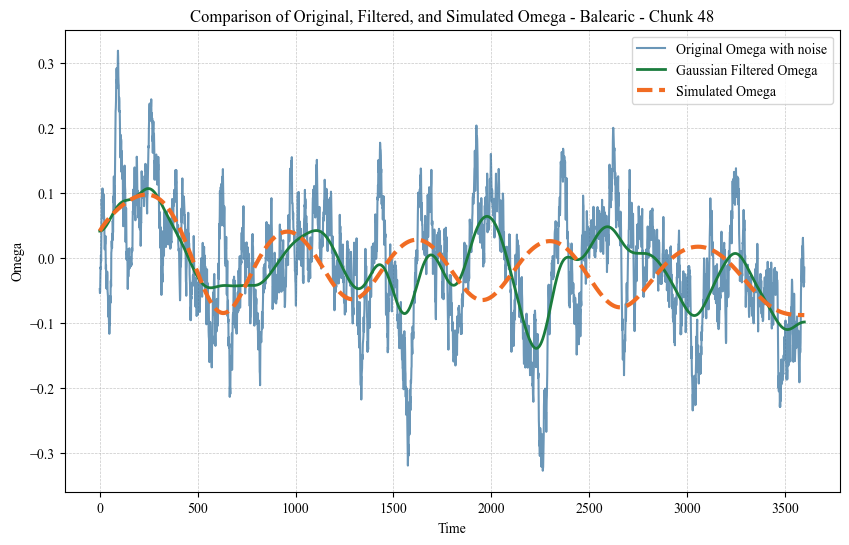

In [69]:
n=47
# Assume that 'omega_filtered' is the variable you want to integrate
initial_conditions = [integrate_data(balearic_data[n]['omega_filtered'].values)[0], 
                      balearic_data[n]['omega_filtered'].iloc[0],0]

# Define time points for simulation
total_time = len(balearic_data[1]['omega_filtered'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original and omega_filtered are available
omega_original = balearic_data[n]['omega'].values  # Replace 'omega' with the actual column name
omega_filtered = balearic_data[n]['omega_filtered'].values

# Simulate and plot results for a specific chunk (e.g., chunk 2)
simulate_sindy_model(balearic_models[n], initial_conditions, time_points, f'Balearic - Chunk {n+1}', omega_original, omega_filtered)
